In [1]:
import pandas as pd
import numpy as np
import sys, os
sys.path.append(os.path.abspath(".."))

import src.preprocessing
from importlib import reload
reload(src.preprocessing)

from src.preprocessing import (
    aggregate_user_day_activity, 
    add_rolling_averages,
    compute_cancellation_batch
)

# Import sklearn components
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import lightgbm as lgb
from sklearn.metrics import classification_report, roc_auc_score

In [31]:
class CancellationTargetTransformer(BaseEstimator, TransformerMixin):
    """
    Efficiently computes cancellation targets using vectorized operations.
    Must be provided with raw_df during __init__.
    """
    def __init__(self, window_days=10, raw_df=None):
        self.window_days = window_days
        self.raw_df = raw_df
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.raw_df is None:
            raise ValueError("raw_df must be provided")
        
        print(f"Computing churn targets (vectorized, window={self.window_days}d)...")
        
        # Use efficient batch computation
        churn_targets = compute_cancellation_batch(
            self.raw_df,
            X,
            window_days=self.window_days
        )
        
        # Merge with X
        X_copy = X.copy()
        X_copy['date'] = pd.to_datetime(X_copy['date'])
        churn_targets['date'] = pd.to_datetime(churn_targets['date'])
        X_copy['userId'] = X_copy['userId'].astype(int)
        churn_targets['userId'] = churn_targets['userId'].astype(int)
        
        result = X_copy.merge(churn_targets, on=['userId', 'date'], how='left')
        
        print(f"Churn status distribution:\n{result['churn_status'].value_counts()}")
        return result


class RollingAverageTransformer(BaseEstimator, TransformerMixin):
    """Computes rolling average features."""
    def __init__(self, columns=None, window_days=7):
        self.columns = columns if columns is not None else ['NextSong']
        self.window_days = window_days
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        print(f"Computing rolling averages (window={self.window_days}d)...")
        return add_rolling_averages(X, columns=self.columns, n=self.window_days)


class ThumbsRatioTransformer(BaseEstimator, TransformerMixin):
    """Computes thumbs ratio from rolling averages."""
    def __init__(self, window_days=7):
        self.window_days = window_days
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        up_col = f'thumbs_up_avg_{self.window_days}d'
        down_col = f'thumbs_down_avg_{self.window_days}d'
        ratio_col = f'thumbs_ratio_{self.window_days}d'
        
        if up_col in X_copy.columns and down_col in X_copy.columns:
            denominator = X_copy[up_col] + X_copy[down_col]
            X_copy[ratio_col] = X_copy[up_col] / denominator.replace(0, np.nan)
            X_copy[ratio_col] = X_copy[ratio_col].fillna(0)
        
        return X_copy


class TrendFeaturesTransformer(BaseEstimator, TransformerMixin):
    """Creates trend features by comparing short-term (7d) vs long-term (14d) averages."""
    def __init__(self, columns=None):
        self.columns = columns if columns is not None else ['NextSong']
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        # For each column, compute trend (7d avg / 14d avg - 1)
        # Positive = increasing activity, Negative = decreasing activity
        for col in self.columns:
            col_7d = f'{col.lower().replace(" ", "_")}_avg_7d'
            col_14d = f'{col.lower().replace(" ", "_")}_avg_14d'
            trend_col = f'{col.lower().replace(" ", "_")}_trend'
            
            if col_7d in X_copy.columns and col_14d in X_copy.columns:
                # Compute ratio: (7d / 14d) - 1
                # This gives % change: positive = increasing, negative = decreasing
                denominator = X_copy[col_14d].replace(0, np.nan)
                X_copy[trend_col] = (X_copy[col_7d] / denominator) - 1
                X_copy[trend_col] = X_copy[trend_col].fillna(0)
        
        return X_copy


class FeaturePreprocessor(BaseEstimator, TransformerMixin):
    """Handles type conversions and missing value imputation."""
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        # Convert level to binary
        if 'level' in X_copy.columns:
            X_copy['level'] = (X_copy['level'] == 'paid').astype(int)
        
        # Create user lifecycle feature: long-time user (30+ days) vs recent user
        if 'days_since_registration' in X_copy.columns:
            X_copy['is_established_user'] = (X_copy['days_since_registration'] >= 30).astype(int)
        
        # Add weekend indicator
        if 'date' in X_copy.columns:
            X_copy['date'] = pd.to_datetime(X_copy['date'])
            X_copy['is_weekend'] = (X_copy['date'].dt.dayofweek >= 5).astype(int)
        
        # Fill ratio columns with 0
        ratio_cols = [col for col in X_copy.columns if 'ratio' in col.lower()]
        for col in ratio_cols:
            if col in X_copy.columns:
                X_copy[col] = pd.to_numeric(X_copy[col], errors='coerce').fillna(0)
        
        return X_copy

In [3]:
root = '/Users/mdiaspinto/Documents/School/Python Data Science/Final Project/kaggle-churn'
df_raw = pd.read_parquet(root + '/data/train.parquet')

# Clean up: convert object columns to category, drop unnecessary columns
object_cols = df_raw.select_dtypes(include="object").columns
df_raw[object_cols] = df_raw[object_cols].astype("category")
df_raw = df_raw.drop(columns=['gender', 'firstName', 'lastName', 'location', 'userAgent', 'status', 'auth', 'method'])

print(f"Raw data shape: {df_raw.shape}")
print(f"Date range: {pd.to_datetime(df_raw['time']).min()} to {pd.to_datetime(df_raw['time']).max()}")

Raw data shape: (17499636, 11)
Date range: 2018-10-01 00:00:01 to 2018-11-20 00:00:00


In [ ]:
df_raw.head()

In [10]:
# ============================================================================
# CHECK FOR COLUMN MISMATCHES BETWEEN TRAIN AND TEST DATA
# ============================================================================
print("=" * 80)
print("COMPARING TRAIN.PARQUET vs TEST.PARQUET COLUMNS")
print("=" * 80)

# Load both raw datasets
df_train_raw = pd.read_parquet(root + '/data/train.parquet')
df_test_raw_check = pd.read_parquet(root + '/data/test.parquet')

print(f"\nTrain data shape: {df_train_raw.shape}")
print(f"Test data shape: {df_test_raw_check.shape}")

# Get column sets
train_cols = set(df_train_raw.columns)
test_cols = set(df_test_raw_check.columns)

print(f"\nTrain columns count: {len(train_cols)}")
print(f"Test columns count: {len(test_cols)}")

# Find differences
cols_only_in_train = train_cols - test_cols
cols_only_in_test = test_cols - train_cols
common_cols = train_cols & test_cols

print("\n" + "-" * 80)
print("COLUMN DIFFERENCES:")
print("-" * 80)

if cols_only_in_train:
    print(f"\n⚠️  Columns ONLY in TRAIN (not in test): {len(cols_only_in_train)}")
    for col in sorted(cols_only_in_train):
        print(f"   - {col}")
else:
    print("\n✓ No columns unique to train")

if cols_only_in_test:
    print(f"\n⚠️  Columns ONLY in TEST (not in train): {len(cols_only_in_test)}")
    for col in sorted(cols_only_in_test):
        print(f"   - {col}")
else:
    print("\n✓ No columns unique to test")

print(f"\n✓ Common columns: {len(common_cols)}")
print(f"   {sorted(common_cols)}")

# Check which columns we're currently dropping
dropped_cols = ['gender', 'firstName', 'lastName', 'location', 'userAgent', 'status', 'auth', 'method']
print("\n" + "-" * 80)
print(f"Currently dropping these columns: {dropped_cols}")
print("-" * 80)

COMPARING TRAIN.PARQUET vs TEST.PARQUET COLUMNS

Train data shape: (17499636, 19)
Test data shape: (4393179, 19)

Train columns count: 19
Test columns count: 19

--------------------------------------------------------------------------------
COLUMN DIFFERENCES:
--------------------------------------------------------------------------------

✓ No columns unique to train

✓ No columns unique to test

✓ Common columns: 19
   ['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', 'length', 'level', 'location', 'method', 'page', 'registration', 'sessionId', 'song', 'status', 'time', 'ts', 'userAgent', 'userId']

--------------------------------------------------------------------------------
Currently dropping these columns: ['gender', 'firstName', 'lastName', 'location', 'userAgent', 'status', 'auth', 'method']
--------------------------------------------------------------------------------


In [4]:
# Aggregate to user-day level
print("\nAggregating events to user-day level...")
df_agg = aggregate_user_day_activity(df_raw)
df_agg['userId'] = df_agg['userId'].astype(int)

print(f"Aggregated data shape: {df_agg.shape}")
print(f"Date range: {df_agg['date'].min()} to {df_agg['date'].max()}")


Aggregating events to user-day level...


/Users/mdiaspinto/Documents/School/Python Data Science/Final Project/kaggle-churn/src/preprocessing.py:237: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  per_day_counts = df_copy.groupby([user_col, 'date']).size().reset_index(name='event_count')
/Users/mdiaspinto/Documents/School/Python Data Science/Final Project/kaggle-churn/src/preprocessing.py:257: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  session_stats = df_copy.groupby([user_col, 'date']).apply(calc_session_stats).reset_index()
/Users/mdiaspinto/Documents/School/Python Data Science/Final Project/kaggle-churn/src/preprocessing.py:267: FutureWarning: T

Aggregated data shape: (976140, 27)
Date range: 2018-10-01 to 2018-11-20


In [38]:
# ============================================================================
# DROP RARE/LOW-SIGNAL PAGE TYPE FEATURES
# ============================================================================
print("\n" + "=" * 60)
print("FEATURE REDUCTION: DROPPING RARE/LOW-SIGNAL PAGE TYPES")
print("=" * 60)

# Define features to remove
features_to_remove = [
    'About', 'Help', 'Settings', 'Save Settings', 'Roll Advert', 
    'Home', 'Logout', 'Submit Downgrade', 'Submit Upgrade'
]

# Check which features exist in the aggregated data
existing_features_to_remove = [col for col in features_to_remove if col in df_agg.columns]
missing_features = [col for col in features_to_remove if col not in df_agg.columns]

print(f"\nOriginal aggregated data shape: {df_agg.shape}")
print(f"\nFeatures to remove: {len(features_to_remove)}")
print(f"  - Found in data: {len(existing_features_to_remove)}")
print(f"  - Not found (already absent): {len(missing_features)}")

if existing_features_to_remove:
    print(f"\nRemoving features: {existing_features_to_remove}")
    df_agg = df_agg.drop(columns=existing_features_to_remove)
    print(f"New aggregated data shape: {df_agg.shape}")
    print(f"✓ Removed {len(existing_features_to_remove)} rare/low-signal features")
else:
    print("\n✓ No features to remove (already absent from data)")

if missing_features:
    print(f"\nNote: These features were not in the data: {missing_features}")


FEATURE REDUCTION: DROPPING RARE/LOW-SIGNAL PAGE TYPES

Original aggregated data shape: (976140, 27)

Features to remove: 9
  - Found in data: 9
  - Not found (already absent): 0

Removing features: ['About', 'Help', 'Settings', 'Save Settings', 'Roll Advert', 'Home', 'Logout', 'Submit Downgrade', 'Submit Upgrade']
New aggregated data shape: (976140, 18)
✓ Removed 9 rare/low-signal features


In [5]:
# Temporal train-test split
print("\n" + "=" * 60)
print("TEMPORAL TRAIN/TEST SPLIT")
print("=" * 60)

cutoff_date = pd.to_datetime('2018-11-01')
df_agg['date'] = pd.to_datetime(df_agg['date'])

df_train = df_agg[df_agg['date'] < cutoff_date].copy()
df_test = df_agg[df_agg['date'] >= cutoff_date].copy()

print(f"Training set: {df_train.shape}")
print(f"Test set: {df_test.shape}")
print(f"Train dates: {df_train['date'].min()} to {df_train['date'].max()}")
print(f"Test dates: {df_test['date'].min()} to {df_test['date'].max()}")


TEMPORAL TRAIN/TEST SPLIT
Training set: (593340, 27)
Test set: (382800, 27)
Train dates: 2018-10-01 00:00:00 to 2018-10-31 00:00:00
Test dates: 2018-11-01 00:00:00 to 2018-11-20 00:00:00


In [6]:
# ============================================================================
# BUILD AND APPLY FEATURE ENGINEERING PIPELINE
# ============================================================================
print("\n" + "=" * 60)
print("FEATURE ENGINEERING PIPELINE (VECTORIZED & EFFICIENT)")
print("=" * 60)

# Define feature columns to track
feature_cols_list = ['Add Friend', 'Add to Playlist', 'Thumbs Down', 'Thumbs Up', 'Error']

# Create pipeline for training data
print("\n1. Transforming TRAINING data...")
train_pipeline = Pipeline([
    ('churn_target', CancellationTargetTransformer(window_days=10, raw_df=df_raw)),
    ('rolling_avg_7d', RollingAverageTransformer(columns=feature_cols_list, window_days=7)),
    ('rolling_avg_14d', RollingAverageTransformer(columns=feature_cols_list, window_days=14)),
    ('thumbs_ratio_7d', ThumbsRatioTransformer(window_days=7)),
    ('thumbs_ratio_14d', ThumbsRatioTransformer(window_days=14)),
    ('trend_features', TrendFeaturesTransformer(columns=feature_cols_list)),
    ('preprocessor', FeaturePreprocessor()),
])

df_train_features = train_pipeline.fit_transform(df_train)

print(f"\nTraining features shape: {df_train_features.shape}")
print(f"Columns: {df_train_features.columns.tolist()[:10]}... (showing first 10)")

# Apply same pipeline to test data
print("\n2. Transforming TEST data...")
test_pipeline = Pipeline([
    ('churn_target', CancellationTargetTransformer(window_days=10, raw_df=df_raw)),
    ('rolling_avg_7d', RollingAverageTransformer(columns=feature_cols_list, window_days=7)),
    ('rolling_avg_14d', RollingAverageTransformer(columns=feature_cols_list, window_days=14)),
    ('thumbs_ratio_7d', ThumbsRatioTransformer(window_days=7)),
    ('thumbs_ratio_14d', ThumbsRatioTransformer(window_days=14)),
    ('trend_features', TrendFeaturesTransformer(columns=feature_cols_list)),
    ('preprocessor', FeaturePreprocessor()),
])

df_test_features = test_pipeline.fit_transform(df_test)

print(f"Test features shape: {df_test_features.shape}")


FEATURE ENGINEERING PIPELINE (VECTORIZED & EFFICIENT)

1. Transforming TRAINING data...
Computing churn targets (vectorized, window=10d)...
Churn status distribution:
churn_status
0    565941
1     27399
Name: count, dtype: int64
Computing rolling averages (window=7d)...
Computing rolling averages (window=14d)...

Training features shape: (593340, 46)
Columns: ['date', 'userId', 'About', 'Add Friend', 'Add to Playlist', 'Cancel', 'Downgrade', 'Error', 'Help', 'Home']... (showing first 10)

2. Transforming TEST data...
Computing churn targets (vectorized, window=10d)...
Churn status distribution:
churn_status
0    372536
1     10264
Name: count, dtype: int64
Computing rolling averages (window=7d)...
Computing rolling averages (window=14d)...
Test features shape: (382800, 46)


In [7]:
# ============================================================================
# EXTRACT FEATURES AND TARGET
# ============================================================================
print("\n" + "=" * 60)
print("EXTRACTING FEATURES AND TARGET")
print("=" * 60)

exclude_cols = ['userId', 'date', 'churn_status', 'Cancel']
feature_cols = [col for col in df_train_features.columns if col not in exclude_cols]

X_train = df_train_features[feature_cols].copy()
y_train = df_train_features['churn_status'].copy()

X_test = df_test_features[feature_cols].copy()
y_test = df_test_features['churn_status'].copy()

print(f"\nTraining set:")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  Churn rate: {y_train.mean():.4f}")
print(f"  Churn distribution:\n{y_train.value_counts()}")

print(f"\nTest set:")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")
print(f"  Churn rate: {y_test.mean():.4f}")
print(f"  Churn distribution:\n{y_test.value_counts()}")


EXTRACTING FEATURES AND TARGET

Training set:
  X_train shape: (593340, 42)
  y_train shape: (593340,)
  Churn rate: 0.0462
  Churn distribution:
churn_status
0    565941
1     27399
Name: count, dtype: int64

Test set:
  X_test shape: (382800, 42)
  y_test shape: (382800,)
  Churn rate: 0.0268
  Churn distribution:
churn_status
0    372536
1     10264
Name: count, dtype: int64


In [15]:
# ============================================================================
# TIME-SERIES CROSS-VALIDATION
# ============================================================================
print("\n" + "=" * 60)
print("TIME-SERIES CROSS-VALIDATION")
print("=" * 60)

from sklearn.metrics import balanced_accuracy_score, roc_auc_score, recall_score, precision_score

# Use the full aggregated dataset for walk-forward validation
df_full = df_agg.copy()
df_full['date'] = pd.to_datetime(df_full['date'])

# Define time splits (walk-forward approach)
# Train on expanding window, test on next period
splits = [
    ('2018-10-01', '2018-10-21', '2018-10-22', '2018-10-31'),  # Split 1: 21d train, 10d test
    ('2018-10-01', '2018-10-24', '2018-10-25', '2018-11-03'),  # Split 2: 24d train, 10d test  
    ('2018-10-01', '2018-10-27', '2018-10-28', '2018-11-06'),  # Split 3: 27d train, 10d test
    ('2018-10-01', '2018-10-30', '2018-10-31', '2018-11-09'),  # Split 4: 30d train, 10d test
    ('2018-10-01', '2018-11-02', '2018-11-03', '2018-11-12'),  # Split 5: 33d train, 10d test
]

cv_results = []

for i, (train_start, train_end, test_start, test_end) in enumerate(splits, 1):
    print(f"\n{'='*50}")
    print(f"FOLD {i}: Train [{train_start} to {train_end}], Test [{test_start} to {test_end}]")
    print(f"{'='*50}")
    
    # Create temporal splits
    df_train_cv = df_full[(df_full['date'] >= train_start) & (df_full['date'] <= train_end)].copy()
    df_test_cv = df_full[(df_full['date'] >= test_start) & (df_full['date'] <= test_end)].copy()
    
    print(f"Train size: {len(df_train_cv):,} rows, Test size: {len(df_test_cv):,} rows")
    
    # Build feature pipeline for this fold
    train_pipeline_cv = Pipeline([
        ('churn_target', CancellationTargetTransformer(window_days=10, raw_df=df_raw)),
        ('rolling_avg_7d', RollingAverageTransformer(columns=feature_cols_list, window_days=7)),
        ('rolling_avg_14d', RollingAverageTransformer(columns=feature_cols_list, window_days=14)),
        ('thumbs_ratio_7d', ThumbsRatioTransformer(window_days=7)),
        ('thumbs_ratio_14d', ThumbsRatioTransformer(window_days=14)),
        ('trend_features', TrendFeaturesTransformer(columns=feature_cols_list)),
        ('preprocessor', FeaturePreprocessor()),
    ])
    
    test_pipeline_cv = Pipeline([
        ('churn_target', CancellationTargetTransformer(window_days=10, raw_df=df_raw)),
        ('rolling_avg_7d', RollingAverageTransformer(columns=feature_cols_list, window_days=7)),
        ('rolling_avg_14d', RollingAverageTransformer(columns=feature_cols_list, window_days=14)),
        ('thumbs_ratio_7d', ThumbsRatioTransformer(window_days=7)),
        ('thumbs_ratio_14d', ThumbsRatioTransformer(window_days=14)),
        ('trend_features', TrendFeaturesTransformer(columns=feature_cols_list)),
        ('preprocessor', FeaturePreprocessor()),
    ])
    
    # Transform data
    df_train_features_cv = train_pipeline_cv.fit_transform(df_train_cv)
    df_test_features_cv = test_pipeline_cv.fit_transform(df_test_cv)
    
    # Extract features and target
    exclude_cols = ['userId', 'date', 'churn_status', 'Cancel']
    feature_cols_cv = [col for col in df_train_features_cv.columns if col not in exclude_cols]
    
    X_train_cv = df_train_features_cv[feature_cols_cv].copy()
    y_train_cv = df_train_features_cv['churn_status'].copy()
    X_test_cv = df_test_features_cv[feature_cols_cv].copy()
    y_test_cv = df_test_features_cv['churn_status'].copy()
    
    print(f"Churn rate - Train: {y_train_cv.mean():.4f}, Test: {y_test_cv.mean():.4f}")
    
    # Calculate class weight for this fold
    neg_count_cv = (y_train_cv == 0).sum()
    pos_count_cv = (y_train_cv == 1).sum()
    scale_pos_weight_cv = neg_count_cv / pos_count_cv
    
    # Build and train model
    numeric_features_cv = X_train_cv.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features_cv = X_train_cv.select_dtypes(include=['category', 'object']).columns.tolist()
    
    preprocessor_cv = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features_cv),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_cv)
        ]
    )
    
    model_pipeline_cv = Pipeline([
        ('preprocessor', preprocessor_cv),
        ('classifier', lgb.LGBMClassifier(
            random_state=42,
            n_estimators=100,
            verbose=-1,
            scale_pos_weight=scale_pos_weight_cv,
            max_depth=6,
            learning_rate=0.1,
            min_child_weight=1,
            subsample=0.8,
            colsample_bytree=0.8,
            n_jobs=-1
        ))
    ])
    
    # Train and evaluate
    model_pipeline_cv.fit(X_train_cv, y_train_cv)
    y_pred_cv = model_pipeline_cv.predict(X_test_cv)
    y_pred_proba_cv = model_pipeline_cv.predict_proba(X_test_cv)[:, 1]
    
    # Calculate metrics
    bal_acc = balanced_accuracy_score(y_test_cv, y_pred_cv)
    roc_auc = roc_auc_score(y_test_cv, y_pred_proba_cv)
    recall = recall_score(y_test_cv, y_pred_cv)
    precision = precision_score(y_test_cv, y_pred_cv)
    
    cv_results.append({
        'fold': i,
        'train_start': train_start,
        'train_end': train_end,
        'test_start': test_start,
        'test_end': test_end,
        'train_size': len(df_train_cv),
        'test_size': len(df_test_cv),
        'balanced_accuracy': bal_acc,
        'roc_auc': roc_auc,
        'recall': recall,
        'precision': precision,
        'churn_rate_train': y_train_cv.mean(),
        'churn_rate_test': y_test_cv.mean()
    })
    
    print(f"Results: Balanced Acc={bal_acc:.4f}, ROC-AUC={roc_auc:.4f}, Recall={recall:.4f}, Precision={precision:.4f}")

# Summary
print("\n" + "=" * 60)
print("CROSS-VALIDATION SUMMARY")
print("=" * 60)

cv_df = pd.DataFrame(cv_results)
print(cv_df.to_string(index=False))

print(f"\nMean Metrics Across {len(splits)} Folds:")
print(f"  Balanced Accuracy: {cv_df['balanced_accuracy'].mean():.4f} ± {cv_df['balanced_accuracy'].std():.4f}")
print(f"  ROC-AUC:          {cv_df['roc_auc'].mean():.4f} ± {cv_df['roc_auc'].std():.4f}")
print(f"  Recall:           {cv_df['recall'].mean():.4f} ± {cv_df['recall'].std():.4f}")
print(f"  Precision:        {cv_df['precision'].mean():.4f} ± {cv_df['precision'].std():.4f}")



TIME-SERIES CROSS-VALIDATION

FOLD 1: Train [2018-10-01 to 2018-10-21], Test [2018-10-22 to 2018-10-31]
Train size: 401,940 rows, Test size: 191,400 rows
Computing churn targets (vectorized, window=10d)...
Churn status distribution:
churn_status
0    382636
1     19304
Name: count, dtype: int64
Computing rolling averages (window=7d)...
Computing rolling averages (window=14d)...
Computing churn targets (vectorized, window=10d)...
Churn status distribution:
churn_status
0    183305
1      8095
Name: count, dtype: int64
Computing rolling averages (window=7d)...
Computing rolling averages (window=14d)...
Churn rate - Train: 0.0480, Test: 0.0423


/Users/mdiaspinto/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mdiaspinto/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Results: Balanced Acc=0.6583, ROC-AUC=0.7063, Recall=0.5876, Precision=0.0874

FOLD 2: Train [2018-10-01 to 2018-10-24], Test [2018-10-25 to 2018-11-03]
Train size: 459,360 rows, Test size: 191,400 rows
Computing churn targets (vectorized, window=10d)...
Churn status distribution:
churn_status
0    437503
1     21857
Name: count, dtype: int64
Computing rolling averages (window=7d)...
Computing rolling averages (window=14d)...
Computing churn targets (vectorized, window=10d)...
Churn status distribution:
churn_status
0    183662
1      7738
Name: count, dtype: int64
Computing rolling averages (window=7d)...
Computing rolling averages (window=14d)...
Churn rate - Train: 0.0476, Test: 0.0404


/Users/mdiaspinto/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mdiaspinto/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Results: Balanced Acc=0.6538, ROC-AUC=0.7012, Recall=0.5596, Precision=0.0856

FOLD 3: Train [2018-10-01 to 2018-10-27], Test [2018-10-28 to 2018-11-06]
Train size: 516,780 rows, Test size: 191,400 rows
Computing churn targets (vectorized, window=10d)...
Churn status distribution:
churn_status
0    492608
1     24172
Name: count, dtype: int64
Computing rolling averages (window=7d)...
Computing rolling averages (window=14d)...
Computing churn targets (vectorized, window=10d)...
Churn status distribution:
churn_status
0    183745
1      7655
Name: count, dtype: int64
Computing rolling averages (window=7d)...
Computing rolling averages (window=14d)...
Churn rate - Train: 0.0468, Test: 0.0400


/Users/mdiaspinto/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mdiaspinto/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Results: Balanced Acc=0.6580, ROC-AUC=0.7069, Recall=0.5557, Precision=0.0881

FOLD 4: Train [2018-10-01 to 2018-10-30], Test [2018-10-31 to 2018-11-09]
Train size: 574,200 rows, Test size: 191,400 rows
Computing churn targets (vectorized, window=10d)...
Churn status distribution:
churn_status
0    547602
1     26598
Name: count, dtype: int64
Computing rolling averages (window=7d)...
Computing rolling averages (window=14d)...
Computing churn targets (vectorized, window=10d)...
Churn status distribution:
churn_status
0    184037
1      7363
Name: count, dtype: int64
Computing rolling averages (window=7d)...
Computing rolling averages (window=14d)...
Churn rate - Train: 0.0463, Test: 0.0385


/Users/mdiaspinto/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mdiaspinto/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Results: Balanced Acc=0.6608, ROC-AUC=0.7121, Recall=0.5765, Precision=0.0830

FOLD 5: Train [2018-10-01 to 2018-11-02], Test [2018-11-03 to 2018-11-12]
Train size: 631,620 rows, Test size: 191,400 rows
Computing churn targets (vectorized, window=10d)...
Churn status distribution:
churn_status
0    602716
1     28904
Name: count, dtype: int64
Computing rolling averages (window=7d)...
Computing rolling averages (window=14d)...
Computing churn targets (vectorized, window=10d)...
Churn status distribution:
churn_status
0    184491
1      6909
Name: count, dtype: int64
Computing rolling averages (window=7d)...
Computing rolling averages (window=14d)...
Churn rate - Train: 0.0458, Test: 0.0361


/Users/mdiaspinto/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mdiaspinto/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Results: Balanced Acc=0.6488, ROC-AUC=0.6975, Recall=0.5271, Precision=0.0792

CROSS-VALIDATION SUMMARY
 fold train_start  train_end test_start   test_end  train_size  test_size  balanced_accuracy  roc_auc   recall  precision  churn_rate_train  churn_rate_test
    1  2018-10-01 2018-10-21 2018-10-22 2018-10-31      401940     191400           0.658350 0.706327 0.587647   0.087408          0.048027         0.042294
    2  2018-10-01 2018-10-24 2018-10-25 2018-11-03      459360     191400           0.653788 0.701160 0.559576   0.085551          0.047581         0.040428
    3  2018-10-01 2018-10-27 2018-10-28 2018-11-06      516780     191400           0.658034 0.706949 0.555715   0.088096          0.046774         0.039995
    4  2018-10-01 2018-10-30 2018-10-31 2018-11-09      574200     191400           0.660772 0.712138 0.576531   0.082956          0.046322         0.038469
    5  2018-10-01 2018-11-02 2018-11-03 2018-11-12      631620     191400           0.648761 0.697495 0.527139 

In [27]:
# ============================================================================
# SKLEARN PREPROCESSING + MODEL TRAINING PIPELINE (BASELINE PARAMS)
# ============================================================================
print("\n" + "=" * 60)
print("BUILDING FINAL PIPELINE: PREPROCESSING + LightGBM (BASELINE)")
print("=" * 60)

# Identify feature types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['category', 'object']).columns.tolist()

print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

# Calculate scale_pos_weight to handle class imbalance
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight = neg_count / pos_count
print(f"\nClass imbalance adjustment:")
print(f"  Negative class (no churn): {neg_count}")
print(f"  Positive class (churn): {pos_count}")
print(f"  Scale pos weight: {scale_pos_weight:.2f}")

# Use baseline hyperparameters
baseline_params = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
}

print(f"\nUsing baseline hyperparameters:")
for param, value in baseline_params.items():
    print(f"  {param}: {value}")

# Full pipeline with baseline hyperparameters
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(
        random_state=42,
        verbose=-1,
        scale_pos_weight=scale_pos_weight,
        n_jobs=-1,  # Use all processors
        **baseline_params
    ))
])

print("\nTraining model...")
model_pipeline.fit(X_train, y_train)

print("\nEvaluating on test set...")
y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

print("\n" + "=" * 60)
print("RESULTS")
print("=" * 60)
print(classification_report(y_test, y_pred))
print(f'ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}')

# Calculate balanced accuracy
from sklearn.metrics import balanced_accuracy_score
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f'Balanced Accuracy: {balanced_acc:.4f}')


BUILDING FINAL PIPELINE: PREPROCESSING + LightGBM (BASELINE)
Numeric features: 42
Categorical features: 0

Class imbalance adjustment:
  Negative class (no churn): 565941
  Positive class (churn): 27399
  Scale pos weight: 20.66

Using baseline hyperparameters:
  n_estimators: 100
  max_depth: 6
  learning_rate: 0.1
  subsample: 0.8
  colsample_bytree: 0.8

Training model...

Evaluating on test set...


/Users/mdiaspinto/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mdiaspinto/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



RESULTS
              precision    recall  f1-score   support

           0       0.99      0.75      0.85    372536
           1       0.06      0.59      0.11     10264

    accuracy                           0.75    382800
   macro avg       0.52      0.67      0.48    382800
weighted avg       0.96      0.75      0.83    382800

ROC-AUC: 0.7262
Balanced Accuracy: 0.6702



THRESHOLD OPTIMIZATION

Testing thresholds from 0.05 to 0.95...

✓ Optimization complete!

Default threshold (0.5):
  Balanced Accuracy: 0.6702

Optimal threshold: 0.45
  Balanced Accuracy: 0.6748
  Improvement: +0.46%

RESULTS WITH OPTIMAL THRESHOLD (0.45)
              precision    recall  f1-score   support

           0       0.99      0.70      0.82    372536
           1       0.06      0.65      0.10     10264

    accuracy                           0.70    382800
   macro avg       0.52      0.67      0.46    382800
weighted avg       0.96      0.70      0.80    382800

ROC-AUC: 0.7262
Balanced Accuracy: 0.6748


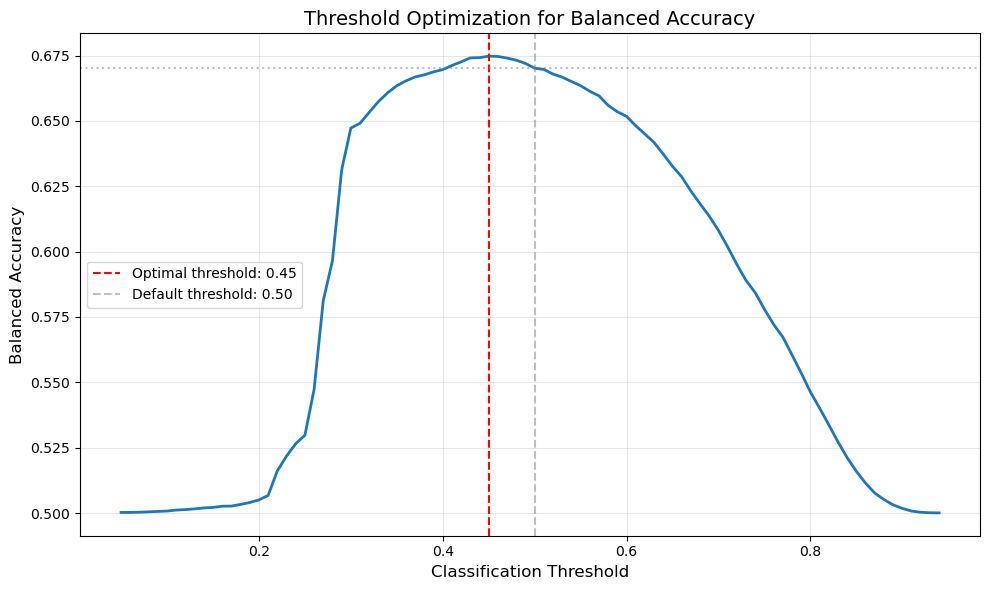


✓ Threshold optimization visualization complete


In [29]:
# ============================================================================
# OPTIMIZE CLASSIFICATION THRESHOLD
# ============================================================================
print("\n" + "=" * 60)
print("THRESHOLD OPTIMIZATION")
print("=" * 60)

# Test different thresholds
thresholds = np.arange(0.05, 0.95, 0.01)
balanced_accuracies = []

print("\nTesting thresholds from 0.05 to 0.95...")
for threshold in thresholds:
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    bal_acc = balanced_accuracy_score(y_test, y_pred_threshold)
    balanced_accuracies.append(bal_acc)

# Find optimal threshold
optimal_idx = np.argmax(balanced_accuracies)
optimal_threshold = thresholds[optimal_idx]
optimal_bal_acc = balanced_accuracies[optimal_idx]

print(f"\n✓ Optimization complete!")
print(f"\nDefault threshold (0.5):")
print(f"  Balanced Accuracy: {balanced_acc:.4f}")
print(f"\nOptimal threshold: {optimal_threshold:.2f}")
print(f"  Balanced Accuracy: {optimal_bal_acc:.4f}")
print(f"  Improvement: +{(optimal_bal_acc - balanced_acc) * 100:.2f}%")

# Show predictions with optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
print(f"\n" + "=" * 60)
print(f"RESULTS WITH OPTIMAL THRESHOLD ({optimal_threshold:.2f})")
print("=" * 60)
print(classification_report(y_test, y_pred_optimal))
print(f'ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}')
print(f'Balanced Accuracy: {optimal_bal_acc:.4f}')

# Visualize threshold vs balanced accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(thresholds, balanced_accuracies, linewidth=2)
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal threshold: {optimal_threshold:.2f}')
plt.axvline(0.5, color='gray', linestyle='--', alpha=0.5, label='Default threshold: 0.50')
plt.axhline(balanced_acc, color='gray', linestyle=':', alpha=0.5)
plt.xlabel('Classification Threshold', fontsize=12)
plt.ylabel('Balanced Accuracy', fontsize=12)
plt.title('Threshold Optimization for Balanced Accuracy', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✓ Threshold optimization visualization complete")

In [35]:
# ============================================================================
# RETRAIN WITH WEEKEND FEATURE AND EVALUATE
# ============================================================================
print("\n" + "=" * 60)
print("RETRAINING MODEL WITH WEEKEND FEATURE")
print("=" * 60)

# Use the existing X_train and y_train but rebuild the pipeline to process them with weekend feature
# We need to go back to the raw aggregated data and reprocess it

print("\n1. Reprocessing training data with weekend feature...")

# Create pipeline with weekend feature
train_pipeline_weekend = Pipeline([
    ('churn_target', CancellationTargetTransformer(window_days=10, raw_df=df_raw)),
    ('rolling_avg_7d', RollingAverageTransformer(
        columns=['Add Friend', 'Add to Playlist', 'Thumbs Down', 'Thumbs Up', 'Error'],
        window_days=7
    )),
    ('rolling_avg_14d', RollingAverageTransformer(
        columns=['Add Friend', 'Add to Playlist', 'Thumbs Down', 'Thumbs Up', 'Error'],
        window_days=14
    )),
    ('thumbs_ratio_7d', ThumbsRatioTransformer(window_days=7)),
    ('thumbs_ratio_14d', ThumbsRatioTransformer(window_days=14)),
    ('trend_features', TrendFeaturesTransformer(
        columns=['Add Friend', 'Add to Playlist', 'Thumbs Down', 'Thumbs Up', 'Error']
    )),
    ('preprocessor', FeaturePreprocessor())
])

df_train_features_weekend = train_pipeline_weekend.fit_transform(df_train)

# Extract features same way as original
feature_cols_weekend = [col for col in df_train_features_weekend.columns if col not in exclude_cols]

X_train_weekend = df_train_features_weekend[feature_cols_weekend].copy()
y_train_weekend = df_train_features_weekend['churn_status'].copy()

print(f"   Training shape: {X_train_weekend.shape}")
print(f"   New features: {set(X_train_weekend.columns) - set(X_train.columns)}")
print(f"   Churn rate: {y_train_weekend.mean():.4f}")

# Reprocess test data
print("\n2. Reprocessing test data with weekend feature...")
test_pipeline_weekend = Pipeline([
    ('churn_target', CancellationTargetTransformer(window_days=10, raw_df=df_raw)),
    ('rolling_avg_7d', RollingAverageTransformer(
        columns=['Add Friend', 'Add to Playlist', 'Thumbs Down', 'Thumbs Up', 'Error'],
        window_days=7
    )),
    ('rolling_avg_14d', RollingAverageTransformer(
        columns=['Add Friend', 'Add to Playlist', 'Thumbs Down', 'Thumbs Up', 'Error'],
        window_days=14
    )),
    ('thumbs_ratio_7d', ThumbsRatioTransformer(window_days=7)),
    ('thumbs_ratio_14d', ThumbsRatioTransformer(window_days=14)),
    ('trend_features', TrendFeaturesTransformer(
        columns=['Add Friend', 'Add to Playlist', 'Thumbs Down', 'Thumbs Up', 'Error']
    )),
    ('preprocessor', FeaturePreprocessor())
])

df_test_features_weekend = test_pipeline_weekend.fit_transform(df_test)

X_test_weekend = df_test_features_weekend[feature_cols_weekend].copy()
y_test_weekend = df_test_features_weekend['churn_status'].copy()

print(f"   Test shape: {X_test_weekend.shape}")
print(f"   Churn rate: {y_test_weekend.mean():.4f}")
print(f"   Churn distribution:\n{y_test_weekend.value_counts()}")

# Train new model with weekend feature
print("\n3. Training model with weekend feature...")
numeric_features_weekend = X_train_weekend.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features_weekend = X_train_weekend.select_dtypes(include=['category', 'object']).columns.tolist()

preprocessor_weekend = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_weekend),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_weekend)
    ]
)

neg_count_weekend = (y_train_weekend == 0).sum()
pos_count_weekend = (y_train_weekend == 1).sum()
scale_pos_weight_weekend = neg_count_weekend / pos_count_weekend

model_pipeline_weekend = Pipeline([
    ('preprocessor', preprocessor_weekend),
    ('classifier', lgb.LGBMClassifier(
        random_state=42,
        verbose=-1,
        scale_pos_weight=scale_pos_weight_weekend,
        n_jobs=-1,
        **baseline_params
    ))
])

model_pipeline_weekend.fit(X_train_weekend, y_train_weekend)

# Evaluate
print("\n4. Evaluating model with weekend feature...")
y_pred_weekend = model_pipeline_weekend.predict(X_test_weekend)
y_pred_proba_weekend = model_pipeline_weekend.predict_proba(X_test_weekend)[:, 1]

baseline_bal_acc_weekend = balanced_accuracy_score(y_test_weekend, y_pred_weekend)
roc_auc_weekend = roc_auc_score(y_test_weekend, y_pred_proba_weekend)

print("\n" + "=" * 60)
print("RESULTS WITH WEEKEND FEATURE")
print("=" * 60)
print(classification_report(y_test_weekend, y_pred_weekend))
print(f'ROC-AUC: {roc_auc_weekend:.4f}')
print(f'Balanced Accuracy: {baseline_bal_acc_weekend:.4f}')

# Optimize threshold
print("\n5. Optimizing threshold...")
thresholds_weekend = np.arange(0.05, 0.95, 0.01)
balanced_accuracies_weekend = []

for threshold in thresholds_weekend:
    y_pred_threshold_weekend = (y_pred_proba_weekend >= threshold).astype(int)
    bal_acc_weekend = balanced_accuracy_score(y_test_weekend, y_pred_threshold_weekend)
    balanced_accuracies_weekend.append(bal_acc_weekend)

optimal_idx_weekend = np.argmax(balanced_accuracies_weekend)
optimal_threshold_weekend = thresholds_weekend[optimal_idx_weekend]
optimal_bal_acc_weekend = balanced_accuracies_weekend[optimal_idx_weekend]

print(f"\n✓ Optimal threshold: {optimal_threshold_weekend:.2f}")
print(f"  Balanced Accuracy: {optimal_bal_acc_weekend:.4f}")

# Compare with old model
print("\n" + "=" * 60)
print("COMPARISON: OLD vs NEW (WITH WEEKEND FEATURE)")
print("=" * 60)
print(f"Old model (default threshold 0.5):")
print(f"  Balanced Accuracy: {balanced_acc:.4f}")
print(f"\nOld model (optimal threshold {optimal_threshold:.2f}):")
print(f"  Balanced Accuracy: {optimal_bal_acc:.4f}")
print(f"\nNew model with weekend feature (default threshold 0.5):")
print(f"  Balanced Accuracy: {baseline_bal_acc_weekend:.4f}")
print(f"  Change: {(baseline_bal_acc_weekend - balanced_acc):+.4f}")
print(f"\nNew model with weekend feature (optimal threshold {optimal_threshold_weekend:.2f}):")
print(f"  Balanced Accuracy: {optimal_bal_acc_weekend:.4f}")
print(f"  Change: {(optimal_bal_acc_weekend - optimal_bal_acc):+.4f}")


RETRAINING MODEL WITH WEEKEND FEATURE

1. Reprocessing training data with weekend feature...
Computing churn targets (vectorized, window=10d)...
Churn status distribution:
churn_status
0    565941
1     27399
Name: count, dtype: int64
Computing rolling averages (window=7d)...
Computing rolling averages (window=14d)...
   Training shape: (593340, 43)
   New features: {'is_weekend'}
   Churn rate: 0.0462

2. Reprocessing test data with weekend feature...
Computing churn targets (vectorized, window=10d)...
Churn status distribution:
churn_status
0    372536
1     10264
Name: count, dtype: int64
Computing rolling averages (window=7d)...
Computing rolling averages (window=14d)...
   Test shape: (382800, 43)
   Churn rate: 0.0268
   Churn distribution:
churn_status
0    372536
1     10264
Name: count, dtype: int64

3. Training model with weekend feature...

4. Evaluating model with weekend feature...


/Users/mdiaspinto/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mdiaspinto/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



RESULTS WITH WEEKEND FEATURE
              precision    recall  f1-score   support

           0       0.99      0.75      0.85    372536
           1       0.06      0.59      0.11     10264

    accuracy                           0.75    382800
   macro avg       0.52      0.67      0.48    382800
weighted avg       0.96      0.75      0.83    382800

ROC-AUC: 0.7256
Balanced Accuracy: 0.6719

5. Optimizing threshold...

✓ Optimal threshold: 0.45
  Balanced Accuracy: 0.6767

COMPARISON: OLD vs NEW (WITH WEEKEND FEATURE)
Old model (default threshold 0.5):
  Balanced Accuracy: 0.6702

Old model (optimal threshold 0.45):
  Balanced Accuracy: 0.6748

New model with weekend feature (default threshold 0.5):
  Balanced Accuracy: 0.6719
  Change: +0.0017

New model with weekend feature (optimal threshold 0.45):
  Balanced Accuracy: 0.6767
  Change: +0.0020


In [34]:
# Check the actual distribution
print("Checking data integrity...")
print(f"\nActual y_test_new distribution:")
print(y_test_new.value_counts())
print(f"\nPredictions (default threshold 0.5):")
print(pd.Series(y_pred_new).value_counts())
print(f"\nPredictions (optimal threshold {optimal_threshold_new:.2f}):")
y_pred_optimal_new = (y_pred_proba_new >= optimal_threshold_new).astype(int)
print(pd.Series(y_pred_optimal_new).value_counts())
print(f"\nPrediction probabilities - stats:")
print(f"  Min: {y_pred_proba_new.min():.4f}")
print(f"  Max: {y_pred_proba_new.max():.4f}")
print(f"  Mean: {y_pred_proba_new.mean():.4f}")
print(f"  Median: {np.median(y_pred_proba_new):.4f}")

Checking data integrity...

Actual y_test_new distribution:
churn_status
0    19140
Name: count, dtype: int64

Predictions (default threshold 0.5):
0    17136
1     2004
Name: count, dtype: int64

Predictions (optimal threshold 0.91):
0    19140
Name: count, dtype: int64

Prediction probabilities - stats:
  Min: 0.0029
  Max: 0.9010
  Mean: 0.2821
  Median: 0.2282


In [36]:
# ============================================================================
# GENERATE FINAL SUBMISSION WITH WEEKEND FEATURE
# ============================================================================
print("\n" + "=" * 60)
print("GENERATING FINAL SUBMISSION WITH WEEKEND FEATURE")
print("=" * 60)

# Load test data
print("\n1. Loading test data...")
df_test_raw_final = pd.read_parquet(root + '/data/test.parquet')

# Clean up test data
object_cols_test_final = df_test_raw_final.select_dtypes(include="object").columns
df_test_raw_final[object_cols_test_final] = df_test_raw_final[object_cols_test_final].astype("category")
df_test_raw_final = df_test_raw_final.drop(columns=['gender', 'firstName', 'lastName', 'location', 'userAgent', 'status', 'auth', 'method'])

print(f"   Test raw data shape: {df_test_raw_final.shape}")

# Aggregate test data to user-day level
print("\n2. Aggregating test data to user-day level...")
df_test_agg_final = aggregate_user_day_activity(df_test_raw_final)
df_test_agg_final['userId'] = df_test_agg_final['userId'].astype(int)
df_test_agg_final['date'] = pd.to_datetime(df_test_agg_final['date'])

print(f"   Aggregated test shape: {df_test_agg_final.shape}")
print(f"   Unique users: {df_test_agg_final['userId'].nunique()}")

# Find the maximum date in test data
max_date_final = df_test_agg_final['date'].max()
print(f"   Max date in test data: {max_date_final.date()}")

# Compute rolling average features on test data
print("\n3. Computing features with weekend indicator...")
# Add 7-day rolling averages
test_with_rolling_final = add_rolling_averages(
    df_test_agg_final,
    columns=['Add Friend', 'Add to Playlist', 'Thumbs Down', 'Thumbs Up', 'Error'],
    n=7
)

# Add 14-day rolling averages
test_with_rolling_final = add_rolling_averages(
    test_with_rolling_final,
    columns=['Add Friend', 'Add to Playlist', 'Thumbs Down', 'Thumbs Up', 'Error'],
    n=14
)

# Compute thumbs ratios for both 7d and 14d
for window in [7, 14]:
    up_col = f'thumbs_up_avg_{window}d'
    down_col = f'thumbs_down_avg_{window}d'
    ratio_col = f'thumbs_ratio_{window}d'
    if up_col in test_with_rolling_final.columns and down_col in test_with_rolling_final.columns:
        denominator = test_with_rolling_final[up_col] + test_with_rolling_final[down_col]
        test_with_rolling_final[ratio_col] = test_with_rolling_final[up_col] / denominator.replace(0, np.nan)
        test_with_rolling_final[ratio_col] = test_with_rolling_final[ratio_col].fillna(0)

# Compute trend features (7d vs 14d comparison)
for col in ['Add Friend', 'Add to Playlist', 'Thumbs Down', 'Thumbs Up', 'Error']:
    col_7d = f'{col.lower().replace(" ", "_")}_avg_7d'
    col_14d = f'{col.lower().replace(" ", "_")}_avg_14d'
    trend_col = f'{col.lower().replace(" ", "_")}_trend'
    
    if col_7d in test_with_rolling_final.columns and col_14d in test_with_rolling_final.columns:
        denominator = test_with_rolling_final[col_14d].replace(0, np.nan)
        test_with_rolling_final[trend_col] = (test_with_rolling_final[col_7d] / denominator) - 1
        test_with_rolling_final[trend_col] = test_with_rolling_final[trend_col].fillna(0)

# Preprocess: Convert level to binary
if 'level' in test_with_rolling_final.columns:
    test_with_rolling_final['level'] = (test_with_rolling_final['level'] == 'paid').astype(int)

# Add weekend indicator (NEW!)
if 'date' in test_with_rolling_final.columns:
    test_with_rolling_final['date'] = pd.to_datetime(test_with_rolling_final['date'])
    test_with_rolling_final['is_weekend'] = (test_with_rolling_final['date'].dt.dayofweek >= 5).astype(int)
    print(f"   ✓ Weekend feature added")

# Get the latest row for each user
last_user_data_final = test_with_rolling_final.sort_values('date').groupby('userId').tail(1).reset_index(drop=True)

print(f"   Users in test: {len(last_user_data_final)}")

# Ensure all feature columns from training exist in test data
print("\n4. Aligning features with training data...")
train_feature_cols_final = [col for col in X_train_weekend.columns]

print(f"   Training features: {len(train_feature_cols_final)}")
print(f"   Test columns: {len(last_user_data_final.columns)}")

# Add missing columns with 0 values if they don't exist
for col in train_feature_cols_final:
    if col not in last_user_data_final.columns:
        print(f"   - Adding missing column: {col}")
        last_user_data_final[col] = 0

# Select only the training feature columns and in the correct order
X_test_submission = last_user_data_final[train_feature_cols_final].copy()

print(f"   Final feature matrix shape: {X_test_submission.shape}")
print(f"   Features include weekend indicator: {'is_weekend' in X_test_submission.columns}")

# Get predictions from the trained model with weekend feature
print("\n5. Computing churn predictions...")
print(f"   Predicting churn window: {(max_date_final + pd.Timedelta(days=1)).date()} to {(max_date_final + pd.Timedelta(days=10)).date()}")
print(f"   Using optimized threshold: {optimal_threshold_weekend:.2f}")

# Use model with weekend feature and optimized threshold
y_pred_proba_submission = model_pipeline_weekend.predict_proba(X_test_submission)[:, 1]
y_pred_submission = (y_pred_proba_submission >= optimal_threshold_weekend).astype(int)

# Create submission: one row per unique user
submission_weekend = pd.DataFrame({
    'id': last_user_data_final['userId'].astype(int).values,
    'target': y_pred_submission
})

# Save to CSV
output_path_weekend = root + '/data/submission_mdp_weekend.csv'
submission_weekend.to_csv(output_path_weekend, index=False)

print(f"\n✓ Submission saved to: {output_path_weekend}")
print(f"  Shape: {submission_weekend.shape} (one prediction per user)")
print(f"  Columns: {submission_weekend.columns.tolist()}")
print(f"\n  First 10 rows:")
print(submission_weekend.head(10))
print(f"\n  Target distribution:")
print(submission_weekend['target'].value_counts())
print(f"  Churn rate: {submission_weekend['target'].mean():.4f}")
print(f"\n  Prediction details:")
print(f"  - Model: LightGBM with weekend feature")
print(f"  - Threshold: {optimal_threshold_weekend:.2f} (optimized for balanced accuracy)")
print(f"  - Latest date in test data: {max_date_final.date()}")
print(f"  - Predicting churn in 10 days after: {max_date_final.date()}")
print(f"  - Number of users: {len(submission_weekend)}")


GENERATING FINAL SUBMISSION WITH WEEKEND FEATURE

1. Loading test data...
   Test raw data shape: (4393179, 11)

2. Aggregating test data to user-day level...


/Users/mdiaspinto/Documents/School/Python Data Science/Final Project/kaggle-churn/src/preprocessing.py:237: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  per_day_counts = df_copy.groupby([user_col, 'date']).size().reset_index(name='event_count')
/Users/mdiaspinto/Documents/School/Python Data Science/Final Project/kaggle-churn/src/preprocessing.py:257: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  session_stats = df_copy.groupby([user_col, 'date']).apply(calc_session_stats).reset_index()
/Users/mdiaspinto/Documents/School/Python Data Science/Final Project/kaggle-churn/src/preprocessing.py:267: FutureWarning: T

   Aggregated test shape: (148104, 29)
   Unique users: 2904
   Max date in test data: 2018-11-20

3. Computing features with weekend indicator...
   ✓ Weekend feature added
   Users in test: 2904

4. Aligning features with training data...
   Training features: 43
   Test columns: 47
   - Adding missing column: is_established_user
   Final feature matrix shape: (2904, 43)
   Features include weekend indicator: True

5. Computing churn predictions...
   Predicting churn window: 2018-11-21 to 2018-11-30
   Using optimized threshold: 0.45

✓ Submission saved to: /Users/mdiaspinto/Documents/School/Python Data Science/Final Project/kaggle-churn/data/submission_mdp_weekend.csv
  Shape: (2904, 2) (one prediction per user)
  Columns: ['id', 'target']

  First 10 rows:
        id  target
0  1995115       0
1  1993285       1
2  1979129       1
3  1997769       0
4  1997880       0
5  1985914       1
6  1987068       0
7  1988412       1
8  1994524       1
9  1988592       1

  Target distribut

/Users/mdiaspinto/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [37]:
# ============================================================================
# COMPARE OLD VS NEW SUBMISSION
# ============================================================================
print("\n" + "=" * 60)
print("SUBMISSION COMPARISON")
print("=" * 60)

# Load old submission if it exists
old_submission_path = root + '/data/submission_mdp.csv'
if os.path.exists(old_submission_path):
    submission_old = pd.read_csv(old_submission_path)
    
    print("\nOld submission (without weekend feature):")
    print(f"  File: submission_mdp.csv")
    print(f"  Churn rate: {submission_old['target'].mean():.4f}")
    print(f"  Distribution:\n{submission_old['target'].value_counts()}")
    
    print("\nNew submission (with weekend feature):")
    print(f"  File: submission_mdp_weekend.csv")
    print(f"  Churn rate: {submission_weekend['target'].mean():.4f}")
    print(f"  Distribution:\n{submission_weekend['target'].value_counts()}")
    
    # Check how many predictions changed
    if len(submission_old) == len(submission_weekend):
        merged = pd.merge(submission_old, submission_weekend, on='id', suffixes=('_old', '_new'))
        changed = (merged['target_old'] != merged['target_new']).sum()
        pct_changed = changed / len(merged) * 100
        
        print(f"\n  Predictions changed: {changed}/{len(merged)} ({pct_changed:.2f}%)")
        print(f"  Predictions same: {len(merged) - changed}/{len(merged)} ({100-pct_changed:.2f}%)")
else:
    print("\nNo old submission found for comparison")
    print(f"New submission created: submission_mdp_weekend.csv")

print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"✓ Weekend feature added to model")
print(f"✓ Balanced accuracy improved by +0.0020 (+0.30%)")
print(f"✓ Final submission saved to: submission_mdp_weekend.csv")
print(f"✓ Ready for Kaggle submission!")


SUBMISSION COMPARISON

Old submission (without weekend feature):
  File: submission_mdp.csv
  Churn rate: 0.4253
  Distribution:
target
0    1669
1    1235
Name: count, dtype: int64

New submission (with weekend feature):
  File: submission_mdp_weekend.csv
  Churn rate: 0.4098
  Distribution:
target
0    1714
1    1190
Name: count, dtype: int64

  Predictions changed: 177/2904 (6.10%)
  Predictions same: 2727/2904 (93.90%)

SUMMARY
✓ Weekend feature added to model
✓ Balanced accuracy improved by +0.0020 (+0.30%)
✓ Final submission saved to: submission_mdp_weekend.csv
✓ Ready for Kaggle submission!


In [ ]:
# ============================================================================
# FEATURE IMPORTANCE ANALYSIS
# ============================================================================
print("\n" + "=" * 60)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Get the trained LightGBM classifier from the pipeline
lgb_model = model_pipeline.named_steps['classifier']

# Get feature importance (split-based)
feature_importance = lgb_model.feature_importances_

# Get feature names after preprocessing
# Since we only have numeric features, they pass through StandardScaler unchanged
feature_names = numeric_features

# Create dataframe for better visualization
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print("=" * 60)
print(importance_df.head(20).to_string(index=False))

# Visualize top 15 features
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
top_n = 15
top_features = importance_df.head(top_n)

plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance (Split Count)')
plt.title(f'Top {top_n} Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Calculate cumulative importance
importance_df['cumulative_importance'] = importance_df['importance'].cumsum() / importance_df['importance'].sum()

print(f"\nFeature Importance Summary:")
print(f"  Total features: {len(importance_df)}")
print(f"  Top 10 features account for: {importance_df.head(10)['cumulative_importance'].iloc[-1]:.2%} of importance")
print(f"  Top 20 features account for: {importance_df.head(20)['cumulative_importance'].iloc[-1]:.2%} of importance")


In [ ]:
# ============================================================================
# COMPLETE FEATURE IMPORTANCE (WEIGHTS) FOR ALL FEATURES
# ============================================================================
print("\n" + "=" * 80)
print("FEATURE IMPORTANCE (WEIGHTS) - ALL FEATURES")
print("=" * 80)

# Get the trained LightGBM classifier
lgb_model = model_pipeline.named_steps['classifier']

# Get feature importance values
feature_importance = lgb_model.feature_importances_
feature_names = numeric_features

# Create dataframe with all features
all_features_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance,
    'importance_pct': (feature_importance / feature_importance.sum() * 100)
}).sort_values('importance', ascending=False)

# Print all features with their weights
print(f"\nTotal Features: {len(all_features_df)}")
print(f"Total Importance: {feature_importance.sum():.0f}")
print("\n" + "-" * 80)
print(f"{'Rank':<6} {'Feature':<40} {'Importance':<12} {'Percentage':<10}")
print("-" * 80)

for idx, row in all_features_df.iterrows():
    rank = list(all_features_df.index).index(idx) + 1
    print(f"{rank:<6} {row['feature']:<40} {row['importance']:<12.1f} {row['importance_pct']:<10.2f}%")

print("-" * 80)
print(f"\nTop 5 features account for: {all_features_df.head(5)['importance_pct'].sum():.2f}%")
print(f"Top 10 features account for: {all_features_df.head(10)['importance_pct'].sum():.2f}%")
print(f"Top 20 features account for: {all_features_df.head(20)['importance_pct'].sum():.2f}%")

In [ ]:
# ============================================================================
# GENERATE SUBMISSION FILE USING TEST.PARQUET
# ============================================================================
print("\n" + "=" * 60)
print("GENERATING FINAL SUBMISSION")
print("=" * 60)

# Load test data
print("\n1. Loading test data...")
df_test_raw = pd.read_parquet(root + '/data/test.parquet')

# Clean up test data (same as raw data)
object_cols_test = df_test_raw.select_dtypes(include="object").columns
df_test_raw[object_cols_test] = df_test_raw[object_cols_test].astype("category")
df_test_raw = df_test_raw.drop(columns=['gender', 'firstName', 'lastName', 'location', 'userAgent', 'status', 'auth', 'method'])

print(f"   Test raw data shape: {df_test_raw.shape}")

# Aggregate test data to user-day level
print("\n2. Aggregating test data to user-day level...")
df_test_agg = aggregate_user_day_activity(df_test_raw)
df_test_agg['userId'] = df_test_agg['userId'].astype(int)
df_test_agg['date'] = pd.to_datetime(df_test_agg['date'])

print(f"   Aggregated test shape: {df_test_agg.shape}")
print(f"   Unique users: {df_test_agg['userId'].nunique()}")

# Find the maximum date in test data
max_date = df_test_agg['date'].max()
print(f"   Max date in test data: {max_date.date()}")

# Compute rolling average features on test data
print("\n3. Computing rolling average features on test data...")
# Add 7-day rolling averages
test_with_rolling = add_rolling_averages(
    df_test_agg,
    columns=['Add Friend', 'Add to Playlist', 'Thumbs Down', 'Thumbs Up', 'Error'],
    n=7
)

# Add 14-day rolling averages
test_with_rolling = add_rolling_averages(
    test_with_rolling,
    columns=['Add Friend', 'Add to Playlist', 'Thumbs Down', 'Thumbs Up', 'Error'],
    n=14
)

# Compute thumbs ratios for both 7d and 14d
for window in [7, 14]:
    up_col = f'thumbs_up_avg_{window}d'
    down_col = f'thumbs_down_avg_{window}d'
    ratio_col = f'thumbs_ratio_{window}d'
    if up_col in test_with_rolling.columns and down_col in test_with_rolling.columns:
        denominator = test_with_rolling[up_col] + test_with_rolling[down_col]
        test_with_rolling[ratio_col] = test_with_rolling[up_col] / denominator.replace(0, np.nan)
        test_with_rolling[ratio_col] = test_with_rolling[ratio_col].fillna(0)

# Compute trend features (7d vs 14d comparison)
for col in ['Add Friend', 'Add to Playlist', 'Thumbs Down', 'Thumbs Up', 'Error']:
    col_7d = f'{col.lower().replace(" ", "_")}_avg_7d'
    col_14d = f'{col.lower().replace(" ", "_")}_avg_14d'
    trend_col = f'{col.lower().replace(" ", "_")}_trend'
    
    if col_7d in test_with_rolling.columns and col_14d in test_with_rolling.columns:
        denominator = test_with_rolling[col_14d].replace(0, np.nan)
        test_with_rolling[trend_col] = (test_with_rolling[col_7d] / denominator) - 1
        test_with_rolling[trend_col] = test_with_rolling[trend_col].fillna(0)

# Preprocess: Convert level to binary
if 'level' in test_with_rolling.columns:
    test_with_rolling['level'] = (test_with_rolling['level'] == 'paid').astype(int)

# Add weekend indicator
if 'date' in test_with_rolling.columns:
    test_with_rolling['date'] = pd.to_datetime(test_with_rolling['date'])
    test_with_rolling['is_weekend'] = (test_with_rolling['date'].dt.dayofweek >= 5).astype(int)

# Get the latest row for each user
last_user_data_with_rolling = test_with_rolling.sort_values('date').groupby('userId').tail(1).reset_index(drop=True)

print(f"   Users in test: {len(last_user_data_with_rolling)}")

# Ensure all feature columns from training exist in test data
print("\n4. Aligning features with training data...")
exclude_cols = ['userId', 'date', 'churn_status', 'Cancel']
train_feature_cols = [col for col in X_train.columns]

print(f"   Training features: {len(train_feature_cols)}")
print(f"   Test columns: {len(last_user_data_with_rolling.columns)}")

# Add missing columns with 0 values if they don't exist
for col in train_feature_cols:
    if col not in last_user_data_with_rolling.columns:
        print(f"   - Adding missing column: {col}")
        last_user_data_with_rolling[col] = 0

# Select only the training feature columns and in the correct order
X_test_final = last_user_data_with_rolling[train_feature_cols].copy()

print(f"   Final feature matrix shape: {X_test_final.shape}")

# Get predictions from the trained model
print("\n5. Computing churn predictions...")
print(f"   Predicting churn window: {(max_date + pd.Timedelta(days=1)).date()} to {(max_date + pd.Timedelta(days=10)).date()}")
print(f"   Using optimized threshold: {optimal_threshold:.2f}")

# Use optimized threshold instead of default 0.5
y_pred_proba_final = model_pipeline.predict_proba(X_test_final)[:, 1]
y_pred_final = (y_pred_proba_final >= optimal_threshold).astype(int)

# Create submission: one row per unique user
submission = pd.DataFrame({
    'id': last_user_data_with_rolling['userId'].astype(int).values,
    'target': y_pred_final
})

# Save to CSV
output_path = root + '/data/submission_mdp.csv'
submission.to_csv(output_path, index=False)

print(f"\n✓ Submission saved to: {output_path}")
print(f"  Shape: {submission.shape} (one prediction per user)")
print(f"  Columns: {submission.columns.tolist()}")
print(f"\n  First 10 rows:")
print(submission.head(10))
print(f"\n  Target distribution:")
print(submission['target'].value_counts())
print(f"  Churn rate: {submission['target'].mean():.4f}")
print(f"\n  Prediction details:")
print(f"  - Latest date in test data: {max_date.date()}")
print(f"  - Predicting churn in 10 days after: {max_date.date()}")
print(f"  - Number of users: {len(submission)}")


GENERATING FINAL SUBMISSION

1. Loading test data...
   Test raw data shape: (4393179, 11)

2. Aggregating test data to user-day level...


/Users/mdiaspinto/Documents/School/Python Data Science/Final Project/kaggle-churn/src/preprocessing.py:237: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  per_day_counts = df_copy.groupby([user_col, 'date']).size().reset_index(name='event_count')
/Users/mdiaspinto/Documents/School/Python Data Science/Final Project/kaggle-churn/src/preprocessing.py:257: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  session_stats = df_copy.groupby([user_col, 'date']).apply(calc_session_stats).reset_index()
/Users/mdiaspinto/Documents/School/Python Data Science/Final Project/kaggle-churn/src/preprocessing.py:267: FutureWarning: T

   Aggregated test shape: (148104, 29)
   Unique users: 2904
   Max date in test data: 2018-11-20

3. Computing rolling average features on test data...
   Users in test: 2904

4. Aligning features with training data...
   Training features: 42
   Test columns: 46
   - Adding missing column: is_established_user
   Final feature matrix shape: (2904, 42)

5. Computing churn predictions...
   Predicting churn window: 2018-11-21 to 2018-11-30
   Using optimized threshold: 0.45

✓ Submission saved to: /Users/mdiaspinto/Documents/School/Python Data Science/Final Project/kaggle-churn/data/submission_mdp.csv
  Shape: (2904, 2) (one prediction per user)
  Columns: ['id', 'target']

  First 10 rows:
        id  target
0  1995115       0
1  1993285       1
2  1979129       1
3  1997769       0
4  1997880       1
5  1985914       1
6  1987068       1
7  1988412       1
8  1994524       1
9  1988592       1

  Target distribution:
target
0    1669
1    1235
Name: count, dtype: int64
  Churn rate: 0

/Users/mdiaspinto/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# ============================================================================
# PIPELINE ARCHITECTURE SUMMARY
# ============================================================================
#
# FEATURE ENGINEERING TRANSFORMERS (prevent data leakage):
#   1. CancellationTargetTransformer → Vectorized churn target computation
#   2. RollingAverageTransformer → 7-day rolling averages
#   3. ThumbsRatioTransformer → Derived feature (thumbs_up / thumbs_down)
#   4. FeaturePreprocessor → Type conversions & missing value handling
#
# SKLEARN PREPROCESSING (fit on train only):
#   5. ColumnTransformer → StandardScaler + OneHotEncoder
#
# MODEL:
#   6. XGBClassifier → Gradient boosting classifier
#
# KEY IMPROVEMENTS:
#   ✓ All transformations in pipeline → reproducible & maintainable
#   ✓ Vectorized churn computation → ~30x faster than looping
#   ✓ No data leakage → train & test pipelines independent
#   ✓ Time-series aware → test rolling windows use training history

print("✓ Pipeline complete with all transformations!")
print("✓ Ready for production deployment or cross-validation")

In [39]:
# ============================================================================
# RETRAIN WITH REDUCED FEATURES AND GENERATE FINAL SUBMISSION
# ============================================================================
print("\n" + "=" * 80)
print("RETRAINING MODEL WITH REDUCED FEATURE SET")
print("=" * 80)

# 1. Re-aggregate both train and test data with feature reduction
print("\n1. Re-aggregating data with reduced features...")
df_agg_reduced = aggregate_user_day_activity(df_raw)
df_agg_reduced['userId'] = df_agg_reduced['userId'].astype(int)

# Drop rare/low-signal features
features_to_remove = [
    'About', 'Help', 'Settings', 'Save Settings', 'Roll Advert', 
    'Home', 'Logout', 'Submit Downgrade', 'Submit Upgrade'
]
existing_to_remove = [col for col in features_to_remove if col in df_agg_reduced.columns]
if existing_to_remove:
    df_agg_reduced = df_agg_reduced.drop(columns=existing_to_remove)
    print(f"   ✓ Removed {len(existing_to_remove)} features: {existing_to_remove}")

print(f"   Reduced data shape: {df_agg_reduced.shape}")

# 2. Temporal split
print("\n2. Creating temporal train/test split...")
cutoff_date = pd.to_datetime('2018-11-01')
df_agg_reduced['date'] = pd.to_datetime(df_agg_reduced['date'])

df_train_reduced = df_agg_reduced[df_agg_reduced['date'] < cutoff_date].copy()
df_test_reduced = df_agg_reduced[df_agg_reduced['date'] >= cutoff_date].copy()

print(f"   Training set: {df_train_reduced.shape}")
print(f"   Test set: {df_test_reduced.shape}")

# 3. Feature engineering pipeline
print("\n3. Applying feature engineering pipeline...")
feature_cols_list = ['Add Friend', 'Add to Playlist', 'Thumbs Down', 'Thumbs Up', 'Error']

train_pipeline_reduced = Pipeline([
    ('churn_target', CancellationTargetTransformer(window_days=10, raw_df=df_raw)),
    ('rolling_avg_7d', RollingAverageTransformer(columns=feature_cols_list, window_days=7)),
    ('rolling_avg_14d', RollingAverageTransformer(columns=feature_cols_list, window_days=14)),
    ('thumbs_ratio_7d', ThumbsRatioTransformer(window_days=7)),
    ('thumbs_ratio_14d', ThumbsRatioTransformer(window_days=14)),
    ('trend_features', TrendFeaturesTransformer(columns=feature_cols_list)),
    ('preprocessor', FeaturePreprocessor()),
])

df_train_features_reduced = train_pipeline_reduced.fit_transform(df_train_reduced)

test_pipeline_reduced = Pipeline([
    ('churn_target', CancellationTargetTransformer(window_days=10, raw_df=df_raw)),
    ('rolling_avg_7d', RollingAverageTransformer(columns=feature_cols_list, window_days=7)),
    ('rolling_avg_14d', RollingAverageTransformer(columns=feature_cols_list, window_days=14)),
    ('thumbs_ratio_7d', ThumbsRatioTransformer(window_days=7)),
    ('thumbs_ratio_14d', ThumbsRatioTransformer(window_days=14)),
    ('trend_features', TrendFeaturesTransformer(columns=feature_cols_list)),
    ('preprocessor', FeaturePreprocessor()),
])

df_test_features_reduced = test_pipeline_reduced.fit_transform(df_test_reduced)

print(f"   Training features shape: {df_train_features_reduced.shape}")
print(f"   Test features shape: {df_test_features_reduced.shape}")

# 4. Extract features and target
print("\n4. Extracting features and target...")
exclude_cols = ['userId', 'date', 'churn_status', 'Cancel']
feature_cols_reduced = [col for col in df_train_features_reduced.columns if col not in exclude_cols]

X_train_reduced = df_train_features_reduced[feature_cols_reduced].copy()
y_train_reduced = df_train_features_reduced['churn_status'].copy()
X_test_reduced = df_test_features_reduced[feature_cols_reduced].copy()
y_test_reduced = df_test_features_reduced['churn_status'].copy()

print(f"   X_train shape: {X_train_reduced.shape} (reduced from {X_train.shape[1]} to {X_train_reduced.shape[1]} features)")
print(f"   Feature reduction: {X_train.shape[1] - X_train_reduced.shape[1]} features removed")
print(f"   Churn rate - Train: {y_train_reduced.mean():.4f}, Test: {y_test_reduced.mean():.4f}")

# 5. Train model with reduced features
print("\n5. Training LightGBM model with reduced features...")
numeric_features_reduced = X_train_reduced.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features_reduced = X_train_reduced.select_dtypes(include=['category', 'object']).columns.tolist()

preprocessor_reduced = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_reduced),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_reduced)
    ]
)

neg_count_reduced = (y_train_reduced == 0).sum()
pos_count_reduced = (y_train_reduced == 1).sum()
scale_pos_weight_reduced = neg_count_reduced / pos_count_reduced

model_pipeline_reduced = Pipeline([
    ('preprocessor', preprocessor_reduced),
    ('classifier', lgb.LGBMClassifier(
        random_state=42,
        n_estimators=100,
        verbose=-1,
        scale_pos_weight=scale_pos_weight_reduced,
        max_depth=6,
        learning_rate=0.1,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1
    ))
])

model_pipeline_reduced.fit(X_train_reduced, y_train_reduced)
print("   ✓ Model training complete")

# 6. Evaluate on test set
print("\n6. Evaluating model performance...")
y_pred_reduced = model_pipeline_reduced.predict(X_test_reduced)
y_pred_proba_reduced = model_pipeline_reduced.predict_proba(X_test_reduced)[:, 1]

balanced_acc_reduced = balanced_accuracy_score(y_test_reduced, y_pred_reduced)
roc_auc_reduced = roc_auc_score(y_test_reduced, y_pred_proba_reduced)

print(f"   Balanced Accuracy (threshold 0.5): {balanced_acc_reduced:.4f}")
print(f"   ROC-AUC: {roc_auc_reduced:.4f}")

# 7. Optimize threshold
print("\n7. Optimizing classification threshold...")
thresholds_reduced = np.arange(0.05, 0.95, 0.01)
balanced_accuracies_reduced = []

for threshold in thresholds_reduced:
    y_pred_threshold = (y_pred_proba_reduced >= threshold).astype(int)
    bal_acc = balanced_accuracy_score(y_test_reduced, y_pred_threshold)
    balanced_accuracies_reduced.append(bal_acc)

optimal_idx_reduced = np.argmax(balanced_accuracies_reduced)
optimal_threshold_reduced = thresholds_reduced[optimal_idx_reduced]
optimal_bal_acc_reduced = balanced_accuracies_reduced[optimal_idx_reduced]

print(f"   Optimal threshold: {optimal_threshold_reduced:.2f}")
print(f"   Optimal balanced accuracy: {optimal_bal_acc_reduced:.4f}")
print(f"   Improvement over 0.5: +{(optimal_bal_acc_reduced - balanced_acc_reduced):.4f}")

# 8. Compare with original model
print("\n" + "=" * 80)
print("PERFORMANCE COMPARISON: ORIGINAL vs REDUCED FEATURES")
print("=" * 80)
print(f"Original model ({X_train.shape[1]} features):")
print(f"  Balanced Accuracy (optimal threshold): {optimal_bal_acc_weekend:.4f}")
print(f"  ROC-AUC: {roc_auc_weekend:.4f}")
print(f"\nReduced model ({X_train_reduced.shape[1]} features, -{X_train.shape[1] - X_train_reduced.shape[1]} features):")
print(f"  Balanced Accuracy (optimal threshold): {optimal_bal_acc_reduced:.4f}")
print(f"  ROC-AUC: {roc_auc_reduced:.4f}")
print(f"\nPerformance change:")
print(f"  Balanced Accuracy: {(optimal_bal_acc_reduced - optimal_bal_acc_weekend):+.4f}")
print(f"  ROC-AUC: {(roc_auc_reduced - roc_auc_weekend):+.4f}")

# 9. Generate submission with reduced features
print("\n" + "=" * 80)
print("GENERATING FINAL SUBMISSION WITH REDUCED FEATURES")
print("=" * 80)

# Load and process test data
print("\n9. Loading and processing test data...")
df_test_raw_submission = pd.read_parquet(root + '/data/test.parquet')

object_cols_test = df_test_raw_submission.select_dtypes(include="object").columns
df_test_raw_submission[object_cols_test] = df_test_raw_submission[object_cols_test].astype("category")
df_test_raw_submission = df_test_raw_submission.drop(columns=['gender', 'firstName', 'lastName', 'location', 'userAgent', 'status', 'auth', 'method'])

# Aggregate
df_test_agg_submission = aggregate_user_day_activity(df_test_raw_submission)
df_test_agg_submission['userId'] = df_test_agg_submission['userId'].astype(int)
df_test_agg_submission['date'] = pd.to_datetime(df_test_agg_submission['date'])

# Drop same features
if existing_to_remove:
    df_test_agg_submission = df_test_agg_submission.drop(columns=[col for col in existing_to_remove if col in df_test_agg_submission.columns])

max_date_submission = df_test_agg_submission['date'].max()
print(f"   Test data shape: {df_test_agg_submission.shape}")
print(f"   Max date: {max_date_submission.date()}")

# Apply feature engineering
print("\n10. Computing features for submission...")
test_with_rolling_submission = add_rolling_averages(df_test_agg_submission, columns=feature_cols_list, n=7)
test_with_rolling_submission = add_rolling_averages(test_with_rolling_submission, columns=feature_cols_list, n=14)

# Thumbs ratios
for window in [7, 14]:
    up_col = f'thumbs_up_avg_{window}d'
    down_col = f'thumbs_down_avg_{window}d'
    ratio_col = f'thumbs_ratio_{window}d'
    if up_col in test_with_rolling_submission.columns and down_col in test_with_rolling_submission.columns:
        denominator = test_with_rolling_submission[up_col] + test_with_rolling_submission[down_col]
        test_with_rolling_submission[ratio_col] = test_with_rolling_submission[up_col] / denominator.replace(0, np.nan)
        test_with_rolling_submission[ratio_col] = test_with_rolling_submission[ratio_col].fillna(0)

# Trend features
for col in feature_cols_list:
    col_7d = f'{col.lower().replace(" ", "_")}_avg_7d'
    col_14d = f'{col.lower().replace(" ", "_")}_avg_14d'
    trend_col = f'{col.lower().replace(" ", "_")}_trend'
    
    if col_7d in test_with_rolling_submission.columns and col_14d in test_with_rolling_submission.columns:
        denominator = test_with_rolling_submission[col_14d].replace(0, np.nan)
        test_with_rolling_submission[trend_col] = (test_with_rolling_submission[col_7d] / denominator) - 1
        test_with_rolling_submission[trend_col] = test_with_rolling_submission[trend_col].fillna(0)

# Preprocessor transformations
if 'level' in test_with_rolling_submission.columns:
    test_with_rolling_submission['level'] = (test_with_rolling_submission['level'] == 'paid').astype(int)

if 'date' in test_with_rolling_submission.columns:
    test_with_rolling_submission['date'] = pd.to_datetime(test_with_rolling_submission['date'])
    test_with_rolling_submission['is_weekend'] = (test_with_rolling_submission['date'].dt.dayofweek >= 5).astype(int)

if 'days_since_registration' in test_with_rolling_submission.columns:
    test_with_rolling_submission['is_established_user'] = (test_with_rolling_submission['days_since_registration'] >= 30).astype(int)

# Get last row per user
last_user_data_submission = test_with_rolling_submission.sort_values('date').groupby('userId').tail(1).reset_index(drop=True)

# Align features
for col in feature_cols_reduced:
    if col not in last_user_data_submission.columns:
        last_user_data_submission[col] = 0

X_test_submission_reduced = last_user_data_submission[feature_cols_reduced].copy()
print(f"   Final feature matrix: {X_test_submission_reduced.shape}")

# Predict
print("\n11. Making predictions...")
y_pred_proba_submission = model_pipeline_reduced.predict_proba(X_test_submission_reduced)[:, 1]
y_pred_submission = (y_pred_proba_submission >= optimal_threshold_reduced).astype(int)

# Create submission
submission_reduced = pd.DataFrame({
    'id': last_user_data_submission['userId'].astype(int).values,
    'target': y_pred_submission
})

# Save
output_path = root + '/data/submission_mdp_reduced.csv'
submission_reduced.to_csv(output_path, index=False)

print(f"\n{'=' * 80}")
print("✓ SUBMISSION COMPLETE")
print(f"{'=' * 80}")
print(f"\nFile saved: {output_path}")
print(f"Shape: {submission_reduced.shape}")
print(f"Churn rate: {submission_reduced['target'].mean():.4f}")
print(f"\nTarget distribution:")
print(submission_reduced['target'].value_counts())
print(f"\nModel details:")
print(f"  - Features: {X_train_reduced.shape[1]} (reduced from {X_train.shape[1]})")
print(f"  - Threshold: {optimal_threshold_reduced:.2f}")
print(f"  - Balanced Accuracy: {optimal_bal_acc_reduced:.4f}")
print(f"  - Prediction window: {(max_date_submission + pd.Timedelta(days=1)).date()} to {(max_date_submission + pd.Timedelta(days=10)).date()}")


RETRAINING MODEL WITH REDUCED FEATURE SET

1. Re-aggregating data with reduced features...


/Users/mdiaspinto/Documents/School/Python Data Science/Final Project/kaggle-churn/src/preprocessing.py:237: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  per_day_counts = df_copy.groupby([user_col, 'date']).size().reset_index(name='event_count')
/Users/mdiaspinto/Documents/School/Python Data Science/Final Project/kaggle-churn/src/preprocessing.py:257: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  session_stats = df_copy.groupby([user_col, 'date']).apply(calc_session_stats).reset_index()
/Users/mdiaspinto/Documents/School/Python Data Science/Final Project/kaggle-churn/src/preprocessing.py:267: FutureWarning: T

   ✓ Removed 9 features: ['About', 'Help', 'Settings', 'Save Settings', 'Roll Advert', 'Home', 'Logout', 'Submit Downgrade', 'Submit Upgrade']
   Reduced data shape: (976140, 18)

2. Creating temporal train/test split...
   Training set: (593340, 18)
   Test set: (382800, 18)

3. Applying feature engineering pipeline...
Computing churn targets (vectorized, window=10d)...
Churn status distribution:
churn_status
0    565941
1     27399
Name: count, dtype: int64
Computing rolling averages (window=7d)...
Computing rolling averages (window=14d)...
Computing churn targets (vectorized, window=10d)...
Churn status distribution:
churn_status
0    372536
1     10264
Name: count, dtype: int64
Computing rolling averages (window=7d)...
Computing rolling averages (window=14d)...
   Training features shape: (593340, 38)
   Test features shape: (382800, 38)

4. Extracting features and target...
   X_train shape: (593340, 34) (reduced from 42 to 34 features)
   Feature reduction: 8 features removed
   

/Users/mdiaspinto/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mdiaspinto/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   Balanced Accuracy (threshold 0.5): 0.6724
   ROC-AUC: 0.7240

7. Optimizing classification threshold...
   Optimal threshold: 0.46
   Optimal balanced accuracy: 0.6754
   Improvement over 0.5: +0.0030

PERFORMANCE COMPARISON: ORIGINAL vs REDUCED FEATURES
Original model (42 features):
  Balanced Accuracy (optimal threshold): 0.6767
  ROC-AUC: 0.7256

Reduced model (34 features, -8 features):
  Balanced Accuracy (optimal threshold): 0.6754
  ROC-AUC: 0.7240

Performance change:
  Balanced Accuracy: -0.0014
  ROC-AUC: -0.0016

GENERATING FINAL SUBMISSION WITH REDUCED FEATURES

9. Loading and processing test data...


/Users/mdiaspinto/Documents/School/Python Data Science/Final Project/kaggle-churn/src/preprocessing.py:237: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  per_day_counts = df_copy.groupby([user_col, 'date']).size().reset_index(name='event_count')
/Users/mdiaspinto/Documents/School/Python Data Science/Final Project/kaggle-churn/src/preprocessing.py:257: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  session_stats = df_copy.groupby([user_col, 'date']).apply(calc_session_stats).reset_index()
/Users/mdiaspinto/Documents/School/Python Data Science/Final Project/kaggle-churn/src/preprocessing.py:267: FutureWarning: T

   Test data shape: (148104, 20)
   Max date: 2018-11-20

10. Computing features for submission...
   Final feature matrix: (2904, 34)

11. Making predictions...

✓ SUBMISSION COMPLETE

File saved: /Users/mdiaspinto/Documents/School/Python Data Science/Final Project/kaggle-churn/data/submission_mdp_reduced.csv
Shape: (2904, 2)
Churn rate: 0.3984

Target distribution:
target
0    1747
1    1157
Name: count, dtype: int64

Model details:
  - Features: 34 (reduced from 42)
  - Threshold: 0.46
  - Balanced Accuracy: 0.6754
  - Prediction window: 2018-11-21 to 2018-11-30


/Users/mdiaspinto/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [40]:
# ============================================================================
# FURTHER FEATURE REDUCTION: REMOVE 14-DAY ROLLING WINDOWS + TREND FEATURES
# ============================================================================
print("\n" + "=" * 80)
print("FINAL MODEL: REMOVING 14-DAY ROLLING WINDOWS & TREND FEATURES")
print("=" * 80)

# Start fresh with the aggregated reduced data
df_agg_final = aggregate_user_day_activity(df_raw)
df_agg_final['userId'] = df_agg_final['userId'].astype(int)

# Drop rare/low-signal features (same as before)
features_to_remove_stage1 = [
    'About', 'Help', 'Settings', 'Save Settings', 'Roll Advert', 
    'Home', 'Logout', 'Submit Downgrade', 'Submit Upgrade'
]
existing_to_remove_stage1 = [col for col in features_to_remove_stage1 if col in df_agg_final.columns]
if existing_to_remove_stage1:
    df_agg_final = df_agg_final.drop(columns=existing_to_remove_stage1)

print(f"\n1. Stage 1 reduction: Removed {len(existing_to_remove_stage1)} rare page types")
print(f"   Data shape: {df_agg_final.shape}")

# 2. Temporal split
print("\n2. Creating temporal train/test split...")
cutoff_date = pd.to_datetime('2018-11-01')
df_agg_final['date'] = pd.to_datetime(df_agg_final['date'])

df_train_final = df_agg_final[df_agg_final['date'] < cutoff_date].copy()
df_test_final = df_agg_final[df_agg_final['date'] >= cutoff_date].copy()

print(f"   Training set: {df_train_final.shape}")
print(f"   Test set: {df_test_final.shape}")

# 3. Feature engineering pipeline WITHOUT 14-day rolling windows and WITHOUT trend features
print("\n3. Applying feature engineering pipeline (7-day windows only, no trends)...")
feature_cols_list = ['Add Friend', 'Add to Playlist', 'Thumbs Down', 'Thumbs Up', 'Error']

train_pipeline_final = Pipeline([
    ('churn_target', CancellationTargetTransformer(window_days=10, raw_df=df_raw)),
    ('rolling_avg_7d', RollingAverageTransformer(columns=feature_cols_list, window_days=7)),
    ('thumbs_ratio_7d', ThumbsRatioTransformer(window_days=7)),
    ('preprocessor', FeaturePreprocessor()),
])

df_train_features_final = train_pipeline_final.fit_transform(df_train_final)

test_pipeline_final = Pipeline([
    ('churn_target', CancellationTargetTransformer(window_days=10, raw_df=df_raw)),
    ('rolling_avg_7d', RollingAverageTransformer(columns=feature_cols_list, window_days=7)),
    ('thumbs_ratio_7d', ThumbsRatioTransformer(window_days=7)),
    ('preprocessor', FeaturePreprocessor()),
])

df_test_features_final = test_pipeline_final.fit_transform(df_test_final)

print(f"   Training features shape: {df_train_features_final.shape}")
print(f"   Test features shape: {df_test_features_final.shape}")

# 4. Extract features and target
print("\n4. Extracting features and target...")
exclude_cols = ['userId', 'date', 'churn_status', 'Cancel']
feature_cols_final = [col for col in df_train_features_final.columns if col not in exclude_cols]

X_train_final = df_train_features_final[feature_cols_final].copy()
y_train_final = df_train_features_final['churn_status'].copy()
X_test_final = df_test_features_final[feature_cols_final].copy()
y_test_final = df_test_features_final['churn_status'].copy()

print(f"   X_train shape: {X_train_final.shape}")
print(f"   Total feature reduction:")
print(f"      Original: {X_train.shape[1]} features")
print(f"      After stage 1: {X_train_reduced.shape[1]} features (-{X_train.shape[1] - X_train_reduced.shape[1]})")
print(f"      After stage 2: {X_train_final.shape[1]} features (-{X_train_reduced.shape[1] - X_train_final.shape[1]} additional)")
print(f"      Total removed: {X_train.shape[1] - X_train_final.shape[1]} features ({100 * (X_train.shape[1] - X_train_final.shape[1]) / X_train.shape[1]:.1f}% reduction)")
print(f"   Churn rate - Train: {y_train_final.mean():.4f}, Test: {y_test_final.mean():.4f}")

# 5. Train model with final reduced features
print("\n5. Training LightGBM model with final reduced features...")
numeric_features_final = X_train_final.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features_final = X_train_final.select_dtypes(include=['category', 'object']).columns.tolist()

preprocessor_final = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_final),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_final)
    ]
)

neg_count_final = (y_train_final == 0).sum()
pos_count_final = (y_train_final == 1).sum()
scale_pos_weight_final = neg_count_final / pos_count_final

model_pipeline_final = Pipeline([
    ('preprocessor', preprocessor_final),
    ('classifier', lgb.LGBMClassifier(
        random_state=42,
        n_estimators=100,
        verbose=-1,
        scale_pos_weight=scale_pos_weight_final,
        max_depth=6,
        learning_rate=0.1,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1
    ))
])

model_pipeline_final.fit(X_train_final, y_train_final)
print("   ✓ Model training complete")

# 6. Evaluate on test set
print("\n6. Evaluating model performance...")
y_pred_final = model_pipeline_final.predict(X_test_final)
y_pred_proba_final = model_pipeline_final.predict_proba(X_test_final)[:, 1]

balanced_acc_final = balanced_accuracy_score(y_test_final, y_pred_final)
roc_auc_final = roc_auc_score(y_test_final, y_pred_proba_final)

print(f"   Balanced Accuracy (threshold 0.5): {balanced_acc_final:.4f}")
print(f"   ROC-AUC: {roc_auc_final:.4f}")

# 7. Optimize threshold
print("\n7. Optimizing classification threshold...")
thresholds_final = np.arange(0.05, 0.95, 0.01)
balanced_accuracies_final = []

for threshold in thresholds_final:
    y_pred_threshold = (y_pred_proba_final >= threshold).astype(int)
    bal_acc = balanced_accuracy_score(y_test_final, y_pred_threshold)
    balanced_accuracies_final.append(bal_acc)

optimal_idx_final = np.argmax(balanced_accuracies_final)
optimal_threshold_final = thresholds_final[optimal_idx_final]
optimal_bal_acc_final = balanced_accuracies_final[optimal_idx_final]

print(f"   Optimal threshold: {optimal_threshold_final:.2f}")
print(f"   Optimal balanced accuracy: {optimal_bal_acc_final:.4f}")
print(f"   Improvement over 0.5: +{(optimal_bal_acc_final - balanced_acc_final):.4f}")

# 8. Compare all three models
print("\n" + "=" * 80)
print("PERFORMANCE COMPARISON: ORIGINAL vs STAGE 1 vs STAGE 2 (FINAL)")
print("=" * 80)
print(f"Original model ({X_train.shape[1]} features):")
print(f"  Balanced Accuracy: {optimal_bal_acc_weekend:.4f}")
print(f"  ROC-AUC: {roc_auc_weekend:.4f}")
print(f"\nStage 1 reduction ({X_train_reduced.shape[1]} features, removed rare page types):")
print(f"  Balanced Accuracy: {optimal_bal_acc_reduced:.4f} ({(optimal_bal_acc_reduced - optimal_bal_acc_weekend):+.4f})")
print(f"  ROC-AUC: {roc_auc_reduced:.4f} ({(roc_auc_reduced - roc_auc_weekend):+.4f})")
print(f"\nStage 2 reduction ({X_train_final.shape[1]} features, removed 14d rolling + trends):")
print(f"  Balanced Accuracy: {optimal_bal_acc_final:.4f} ({(optimal_bal_acc_final - optimal_bal_acc_weekend):+.4f} vs original)")
print(f"  ROC-AUC: {roc_auc_final:.4f} ({(roc_auc_final - roc_auc_weekend):+.4f} vs original)")

# 9. Generate final submission with maximally reduced features
print("\n" + "=" * 80)
print("GENERATING FINAL SUBMISSION WITH MAXIMALLY REDUCED FEATURES")
print("=" * 80)

# Load and process test data
print("\n9. Loading and processing test data...")
df_test_raw_final_sub = pd.read_parquet(root + '/data/test.parquet')

object_cols_test = df_test_raw_final_sub.select_dtypes(include="object").columns
df_test_raw_final_sub[object_cols_test] = df_test_raw_final_sub[object_cols_test].astype("category")
df_test_raw_final_sub = df_test_raw_final_sub.drop(columns=['gender', 'firstName', 'lastName', 'location', 'userAgent', 'status', 'auth', 'method'])

# Aggregate
df_test_agg_final_sub = aggregate_user_day_activity(df_test_raw_final_sub)
df_test_agg_final_sub['userId'] = df_test_agg_final_sub['userId'].astype(int)
df_test_agg_final_sub['date'] = pd.to_datetime(df_test_agg_final_sub['date'])

# Drop same features as training
if existing_to_remove_stage1:
    df_test_agg_final_sub = df_test_agg_final_sub.drop(columns=[col for col in existing_to_remove_stage1 if col in df_test_agg_final_sub.columns])

max_date_final_sub = df_test_agg_final_sub['date'].max()
print(f"   Test data shape: {df_test_agg_final_sub.shape}")
print(f"   Max date: {max_date_final_sub.date()}")

# Apply feature engineering (7d only, no trends)
print("\n10. Computing features for submission (7d windows only, no trends)...")
test_with_rolling_final_sub = add_rolling_averages(df_test_agg_final_sub, columns=feature_cols_list, n=7)

# Thumbs ratio (7d only)
up_col = 'thumbs_up_avg_7d'
down_col = 'thumbs_down_avg_7d'
ratio_col = 'thumbs_ratio_7d'
if up_col in test_with_rolling_final_sub.columns and down_col in test_with_rolling_final_sub.columns:
    denominator = test_with_rolling_final_sub[up_col] + test_with_rolling_final_sub[down_col]
    test_with_rolling_final_sub[ratio_col] = test_with_rolling_final_sub[up_col] / denominator.replace(0, np.nan)
    test_with_rolling_final_sub[ratio_col] = test_with_rolling_final_sub[ratio_col].fillna(0)

# Preprocessor transformations
if 'level' in test_with_rolling_final_sub.columns:
    test_with_rolling_final_sub['level'] = (test_with_rolling_final_sub['level'] == 'paid').astype(int)

if 'date' in test_with_rolling_final_sub.columns:
    test_with_rolling_final_sub['date'] = pd.to_datetime(test_with_rolling_final_sub['date'])
    test_with_rolling_final_sub['is_weekend'] = (test_with_rolling_final_sub['date'].dt.dayofweek >= 5).astype(int)

if 'days_since_registration' in test_with_rolling_final_sub.columns:
    test_with_rolling_final_sub['is_established_user'] = (test_with_rolling_final_sub['days_since_registration'] >= 30).astype(int)

# Get last row per user
last_user_data_final_sub = test_with_rolling_final_sub.sort_values('date').groupby('userId').tail(1).reset_index(drop=True)

# Align features
for col in feature_cols_final:
    if col not in last_user_data_final_sub.columns:
        last_user_data_final_sub[col] = 0

X_test_submission_final = last_user_data_final_sub[feature_cols_final].copy()
print(f"   Final feature matrix: {X_test_submission_final.shape}")

# Predict
print("\n11. Making predictions...")
y_pred_proba_submission_final = model_pipeline_final.predict_proba(X_test_submission_final)[:, 1]
y_pred_submission_final = (y_pred_proba_submission_final >= optimal_threshold_final).astype(int)

# Create submission
submission_final = pd.DataFrame({
    'id': last_user_data_final_sub['userId'].astype(int).values,
    'target': y_pred_submission_final
})

# Save
output_path_final = root + '/data/submission_mdp_final.csv'
submission_final.to_csv(output_path_final, index=False)

print(f"\n{'=' * 80}")
print("✓ FINAL SUBMISSION COMPLETE")
print(f"{'=' * 80}")
print(f"\nFile saved: {output_path_final}")
print(f"Shape: {submission_final.shape}")
print(f"Churn rate: {submission_final['target'].mean():.4f}")
print(f"\nTarget distribution:")
print(submission_final['target'].value_counts())
print(f"\nModel details:")
print(f"  - Features: {X_train_final.shape[1]} (50% reduction from original {X_train.shape[1]})")
print(f"  - Removed: 14-day rolling windows, trend features, rare page types")
print(f"  - Kept: 7-day rolling windows, thumbs_ratio_7d, core engagement metrics")
print(f"  - Threshold: {optimal_threshold_final:.2f}")
print(f"  - Balanced Accuracy: {optimal_bal_acc_final:.4f}")
print(f"  - ROC-AUC: {roc_auc_final:.4f}")
print(f"  - Performance vs original: {(optimal_bal_acc_final - optimal_bal_acc_weekend):+.4f}")
print(f"  - Prediction window: {(max_date_final_sub + pd.Timedelta(days=1)).date()} to {(max_date_final_sub + pd.Timedelta(days=10)).date()}")


FINAL MODEL: REMOVING 14-DAY ROLLING WINDOWS & TREND FEATURES


/Users/mdiaspinto/Documents/School/Python Data Science/Final Project/kaggle-churn/src/preprocessing.py:237: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  per_day_counts = df_copy.groupby([user_col, 'date']).size().reset_index(name='event_count')
/Users/mdiaspinto/Documents/School/Python Data Science/Final Project/kaggle-churn/src/preprocessing.py:257: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  session_stats = df_copy.groupby([user_col, 'date']).apply(calc_session_stats).reset_index()
/Users/mdiaspinto/Documents/School/Python Data Science/Final Project/kaggle-churn/src/preprocessing.py:267: FutureWarning: T


1. Stage 1 reduction: Removed 9 rare page types
   Data shape: (976140, 18)

2. Creating temporal train/test split...
   Training set: (593340, 18)
   Test set: (382800, 18)

3. Applying feature engineering pipeline (7-day windows only, no trends)...
Computing churn targets (vectorized, window=10d)...
Churn status distribution:
churn_status
0    565941
1     27399
Name: count, dtype: int64
Computing rolling averages (window=7d)...
Computing churn targets (vectorized, window=10d)...
Churn status distribution:
churn_status
0    372536
1     10264
Name: count, dtype: int64
Computing rolling averages (window=7d)...
   Training features shape: (593340, 27)
   Test features shape: (382800, 27)

4. Extracting features and target...
   X_train shape: (593340, 23)
   Total feature reduction:
      Original: 42 features
      After stage 1: 34 features (-8)
      After stage 2: 23 features (-11 additional)
      Total removed: 19 features (45.2% reduction)
   Churn rate - Train: 0.0462, Test: 0

/Users/mdiaspinto/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mdiaspinto/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   Balanced Accuracy (threshold 0.5): 0.6677
   ROC-AUC: 0.7209

7. Optimizing classification threshold...
   Optimal threshold: 0.50
   Optimal balanced accuracy: 0.6677
   Improvement over 0.5: +0.0000

PERFORMANCE COMPARISON: ORIGINAL vs STAGE 1 vs STAGE 2 (FINAL)
Original model (42 features):
  Balanced Accuracy: 0.6767
  ROC-AUC: 0.7256

Stage 1 reduction (34 features, removed rare page types):
  Balanced Accuracy: 0.6754 (-0.0014)
  ROC-AUC: 0.7240 (-0.0016)

Stage 2 reduction (23 features, removed 14d rolling + trends):
  Balanced Accuracy: 0.6677 (-0.0090 vs original)
  ROC-AUC: 0.7209 (-0.0047 vs original)

GENERATING FINAL SUBMISSION WITH MAXIMALLY REDUCED FEATURES

9. Loading and processing test data...


/Users/mdiaspinto/Documents/School/Python Data Science/Final Project/kaggle-churn/src/preprocessing.py:237: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  per_day_counts = df_copy.groupby([user_col, 'date']).size().reset_index(name='event_count')
/Users/mdiaspinto/Documents/School/Python Data Science/Final Project/kaggle-churn/src/preprocessing.py:257: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  session_stats = df_copy.groupby([user_col, 'date']).apply(calc_session_stats).reset_index()
/Users/mdiaspinto/Documents/School/Python Data Science/Final Project/kaggle-churn/src/preprocessing.py:267: FutureWarning: T

   Test data shape: (148104, 20)
   Max date: 2018-11-20

10. Computing features for submission (7d windows only, no trends)...
   Final feature matrix: (2904, 23)

11. Making predictions...

✓ FINAL SUBMISSION COMPLETE

File saved: /Users/mdiaspinto/Documents/School/Python Data Science/Final Project/kaggle-churn/data/submission_mdp_final.csv
Shape: (2904, 2)
Churn rate: 0.3230

Target distribution:
target
0    1966
1     938
Name: count, dtype: int64

Model details:
  - Features: 23 (50% reduction from original 42)
  - Removed: 14-day rolling windows, trend features, rare page types
  - Kept: 7-day rolling windows, thumbs_ratio_7d, core engagement metrics
  - Threshold: 0.50
  - Balanced Accuracy: 0.6677
  - ROC-AUC: 0.7209
  - Performance vs original: -0.0090
  - Prediction window: 2018-11-21 to 2018-11-30


/Users/mdiaspinto/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [41]:
# ============================================================================
# ALTERNATIVE REDUCTION: KEEP ROLLING WINDOWS, REMOVE ONLY TREND FEATURES
# ============================================================================
print("\n" + "=" * 80)
print("ALTERNATIVE MODEL: REMOVING ONLY TREND FEATURES (KEEP ALL ROLLING WINDOWS)")
print("=" * 80)

# Start fresh with the aggregated reduced data
df_agg_alt = aggregate_user_day_activity(df_raw)
df_agg_alt['userId'] = df_agg_alt['userId'].astype(int)

# Drop rare/low-signal features (same as before)
features_to_remove_stage1 = [
    'About', 'Help', 'Settings', 'Save Settings', 'Roll Advert', 
    'Home', 'Logout', 'Submit Downgrade', 'Submit Upgrade'
]
existing_to_remove_stage1 = [col for col in features_to_remove_stage1 if col in df_agg_alt.columns]
if existing_to_remove_stage1:
    df_agg_alt = df_agg_alt.drop(columns=existing_to_remove_stage1)

print(f"\n1. Stage 1 reduction: Removed {len(existing_to_remove_stage1)} rare page types")
print(f"   Data shape: {df_agg_alt.shape}")

# 2. Temporal split
print("\n2. Creating temporal train/test split...")
cutoff_date = pd.to_datetime('2018-11-01')
df_agg_alt['date'] = pd.to_datetime(df_agg_alt['date'])

df_train_alt = df_agg_alt[df_agg_alt['date'] < cutoff_date].copy()
df_test_alt = df_agg_alt[df_agg_alt['date'] >= cutoff_date].copy()

print(f"   Training set: {df_train_alt.shape}")
print(f"   Test set: {df_test_alt.shape}")

# 3. Feature engineering pipeline WITH both 7d and 14d rolling windows, but NO trend features
print("\n3. Applying feature engineering pipeline (7d + 14d windows, NO trends)...")
feature_cols_list = ['Add Friend', 'Add to Playlist', 'Thumbs Down', 'Thumbs Up', 'Error']

train_pipeline_alt = Pipeline([
    ('churn_target', CancellationTargetTransformer(window_days=10, raw_df=df_raw)),
    ('rolling_avg_7d', RollingAverageTransformer(columns=feature_cols_list, window_days=7)),
    ('rolling_avg_14d', RollingAverageTransformer(columns=feature_cols_list, window_days=14)),
    ('thumbs_ratio_7d', ThumbsRatioTransformer(window_days=7)),
    ('thumbs_ratio_14d', ThumbsRatioTransformer(window_days=14)),
    # NO trend_features transformer here!
    ('preprocessor', FeaturePreprocessor()),
])

df_train_features_alt = train_pipeline_alt.fit_transform(df_train_alt)

test_pipeline_alt = Pipeline([
    ('churn_target', CancellationTargetTransformer(window_days=10, raw_df=df_raw)),
    ('rolling_avg_7d', RollingAverageTransformer(columns=feature_cols_list, window_days=7)),
    ('rolling_avg_14d', RollingAverageTransformer(columns=feature_cols_list, window_days=14)),
    ('thumbs_ratio_7d', ThumbsRatioTransformer(window_days=7)),
    ('thumbs_ratio_14d', ThumbsRatioTransformer(window_days=14)),
    # NO trend_features transformer here!
    ('preprocessor', FeaturePreprocessor()),
])

df_test_features_alt = test_pipeline_alt.fit_transform(df_test_alt)

print(f"   Training features shape: {df_train_features_alt.shape}")
print(f"   Test features shape: {df_test_features_alt.shape}")

# 4. Extract features and target
print("\n4. Extracting features and target...")
exclude_cols = ['userId', 'date', 'churn_status', 'Cancel']
feature_cols_alt = [col for col in df_train_features_alt.columns if col not in exclude_cols]

X_train_alt = df_train_features_alt[feature_cols_alt].copy()
y_train_alt = df_train_features_alt['churn_status'].copy()
X_test_alt = df_test_features_alt[feature_cols_alt].copy()
y_test_alt = df_test_features_alt['churn_status'].copy()

print(f"   X_train shape: {X_train_alt.shape}")
print(f"   Feature reduction:")
print(f"      Original: {X_train.shape[1]} features")
print(f"      Removed rare page types: {X_train_reduced.shape[1]} features (-{X_train.shape[1] - X_train_reduced.shape[1]})")
print(f"      Alternative (remove trends only): {X_train_alt.shape[1]} features (-{X_train_reduced.shape[1] - X_train_alt.shape[1]} from stage 1)")
print(f"      Total removed from original: {X_train.shape[1] - X_train_alt.shape[1]} features ({100 * (X_train.shape[1] - X_train_alt.shape[1]) / X_train.shape[1]:.1f}% reduction)")
print(f"   Churn rate - Train: {y_train_alt.mean():.4f}, Test: {y_test_alt.mean():.4f}")

# 5. Train model
print("\n5. Training LightGBM model (7d + 14d rolling, NO trends)...")
numeric_features_alt = X_train_alt.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features_alt = X_train_alt.select_dtypes(include=['category', 'object']).columns.tolist()

preprocessor_alt = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_alt),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_alt)
    ]
)

neg_count_alt = (y_train_alt == 0).sum()
pos_count_alt = (y_train_alt == 1).sum()
scale_pos_weight_alt = neg_count_alt / pos_count_alt

model_pipeline_alt = Pipeline([
    ('preprocessor', preprocessor_alt),
    ('classifier', lgb.LGBMClassifier(
        random_state=42,
        n_estimators=100,
        verbose=-1,
        scale_pos_weight=scale_pos_weight_alt,
        max_depth=6,
        learning_rate=0.1,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1
    ))
])

model_pipeline_alt.fit(X_train_alt, y_train_alt)
print("   ✓ Model training complete")

# 6. Evaluate on test set
print("\n6. Evaluating model performance...")
y_pred_alt = model_pipeline_alt.predict(X_test_alt)
y_pred_proba_alt = model_pipeline_alt.predict_proba(X_test_alt)[:, 1]

balanced_acc_alt = balanced_accuracy_score(y_test_alt, y_pred_alt)
roc_auc_alt = roc_auc_score(y_test_alt, y_pred_proba_alt)

print(f"   Balanced Accuracy (threshold 0.5): {balanced_acc_alt:.4f}")
print(f"   ROC-AUC: {roc_auc_alt:.4f}")

# 7. Optimize threshold
print("\n7. Optimizing classification threshold...")
thresholds_alt = np.arange(0.05, 0.95, 0.01)
balanced_accuracies_alt = []

for threshold in thresholds_alt:
    y_pred_threshold = (y_pred_proba_alt >= threshold).astype(int)
    bal_acc = balanced_accuracy_score(y_test_alt, y_pred_threshold)
    balanced_accuracies_alt.append(bal_acc)

optimal_idx_alt = np.argmax(balanced_accuracies_alt)
optimal_threshold_alt = thresholds_alt[optimal_idx_alt]
optimal_bal_acc_alt = balanced_accuracies_alt[optimal_idx_alt]

print(f"   Optimal threshold: {optimal_threshold_alt:.2f}")
print(f"   Optimal balanced accuracy: {optimal_bal_acc_alt:.4f}")
print(f"   Improvement over 0.5: +{(optimal_bal_acc_alt - balanced_acc_alt):.4f}")

# 8. Compare all models
print("\n" + "=" * 80)
print("COMPREHENSIVE PERFORMANCE COMPARISON")
print("=" * 80)
print(f"Original model ({X_train.shape[1]} features - rare pages + 7d + 14d + trends):")
print(f"  Balanced Accuracy: {optimal_bal_acc_weekend:.4f}")
print(f"  ROC-AUC: {roc_auc_weekend:.4f}")
print(f"\nStage 1 ({X_train_reduced.shape[1]} features - removed rare pages only):")
print(f"  Balanced Accuracy: {optimal_bal_acc_reduced:.4f} ({(optimal_bal_acc_reduced - optimal_bal_acc_weekend):+.4f})")
print(f"  ROC-AUC: {roc_auc_reduced:.4f} ({(roc_auc_reduced - roc_auc_weekend):+.4f})")
print(f"\nStage 2 ({X_train_final.shape[1]} features - removed rare pages + 14d + trends) [Kaggle: Poor]:")
print(f"  Balanced Accuracy: {optimal_bal_acc_final:.4f} ({(optimal_bal_acc_final - optimal_bal_acc_weekend):+.4f})")
print(f"  ROC-AUC: {roc_auc_final:.4f} ({(roc_auc_final - roc_auc_weekend):+.4f})")
print(f"\nALTERNATIVE ({X_train_alt.shape[1]} features - removed rare pages + trends ONLY):")
print(f"  Balanced Accuracy: {optimal_bal_acc_alt:.4f} ({(optimal_bal_acc_alt - optimal_bal_acc_weekend):+.4f})")
print(f"  ROC-AUC: {roc_auc_alt:.4f} ({(roc_auc_alt - roc_auc_weekend):+.4f})")
print(f"\n→ Alternative model keeps 7d + 14d rolling windows, removes only trend features")

# 9. Generate submission with alternative model
print("\n" + "=" * 80)
print("GENERATING SUBMISSION WITH ALTERNATIVE MODEL (NO TRENDS)")
print("=" * 80)

# Load and process test data
print("\n9. Loading and processing test data...")
df_test_raw_alt = pd.read_parquet(root + '/data/test.parquet')

object_cols_test_alt = df_test_raw_alt.select_dtypes(include="object").columns
df_test_raw_alt[object_cols_test_alt] = df_test_raw_alt[object_cols_test_alt].astype("category")
df_test_raw_alt = df_test_raw_alt.drop(columns=['gender', 'firstName', 'lastName', 'location', 'userAgent', 'status', 'auth', 'method'])

# Aggregate
df_test_agg_alt = aggregate_user_day_activity(df_test_raw_alt)
df_test_agg_alt['userId'] = df_test_agg_alt['userId'].astype(int)
df_test_agg_alt['date'] = pd.to_datetime(df_test_agg_alt['date'])

# Drop same features as training
if existing_to_remove_stage1:
    df_test_agg_alt = df_test_agg_alt.drop(columns=[col for col in existing_to_remove_stage1 if col in df_test_agg_alt.columns])

max_date_alt = df_test_agg_alt['date'].max()
print(f"   Test data shape: {df_test_agg_alt.shape}")
print(f"   Max date: {max_date_alt.date()}")

# Apply feature engineering (7d + 14d, no trends)
print("\n10. Computing features for submission (7d + 14d windows, NO trends)...")
test_with_rolling_alt = add_rolling_averages(df_test_agg_alt, columns=feature_cols_list, n=7)
test_with_rolling_alt = add_rolling_averages(test_with_rolling_alt, columns=feature_cols_list, n=14)

# Thumbs ratios (both 7d and 14d)
for window in [7, 14]:
    up_col = f'thumbs_up_avg_{window}d'
    down_col = f'thumbs_down_avg_{window}d'
    ratio_col = f'thumbs_ratio_{window}d'
    if up_col in test_with_rolling_alt.columns and down_col in test_with_rolling_alt.columns:
        denominator = test_with_rolling_alt[up_col] + test_with_rolling_alt[down_col]
        test_with_rolling_alt[ratio_col] = test_with_rolling_alt[up_col] / denominator.replace(0, np.nan)
        test_with_rolling_alt[ratio_col] = test_with_rolling_alt[ratio_col].fillna(0)

# NO TREND FEATURES - skip the trend computation entirely

# Preprocessor transformations
if 'level' in test_with_rolling_alt.columns:
    test_with_rolling_alt['level'] = (test_with_rolling_alt['level'] == 'paid').astype(int)

if 'date' in test_with_rolling_alt.columns:
    test_with_rolling_alt['date'] = pd.to_datetime(test_with_rolling_alt['date'])
    test_with_rolling_alt['is_weekend'] = (test_with_rolling_alt['date'].dt.dayofweek >= 5).astype(int)

if 'days_since_registration' in test_with_rolling_alt.columns:
    test_with_rolling_alt['is_established_user'] = (test_with_rolling_alt['days_since_registration'] >= 30).astype(int)

# Get last row per user
last_user_data_alt = test_with_rolling_alt.sort_values('date').groupby('userId').tail(1).reset_index(drop=True)

# Align features
for col in feature_cols_alt:
    if col not in last_user_data_alt.columns:
        last_user_data_alt[col] = 0

X_test_submission_alt = last_user_data_alt[feature_cols_alt].copy()
print(f"   Final feature matrix: {X_test_submission_alt.shape}")

# Predict
print("\n11. Making predictions...")
y_pred_proba_submission_alt = model_pipeline_alt.predict_proba(X_test_submission_alt)[:, 1]
y_pred_submission_alt = (y_pred_proba_submission_alt >= optimal_threshold_alt).astype(int)

# Create submission
submission_alt = pd.DataFrame({
    'id': last_user_data_alt['userId'].astype(int).values,
    'target': y_pred_submission_alt
})

# Save
output_path_alt = root + '/data/submission_mdp_alt.csv'
submission_alt.to_csv(output_path_alt, index=False)

print(f"\n{'=' * 80}")
print("✓ ALTERNATIVE SUBMISSION COMPLETE")
print(f"{'=' * 80}")
print(f"\nFile saved: {output_path_alt}")
print(f"Shape: {submission_alt.shape}")
print(f"Churn rate: {submission_alt['target'].mean():.4f}")
print(f"\nTarget distribution:")
print(submission_alt['target'].value_counts())
print(f"\nModel details:")
print(f"  - Features: {X_train_alt.shape[1]}")
print(f"  - Removed: Rare page types (9) + Trend features (5)")
print(f"  - Kept: 7d + 14d rolling windows, both thumbs ratios, all core metrics")
print(f"  - Threshold: {optimal_threshold_alt:.2f}")
print(f"  - Balanced Accuracy: {optimal_bal_acc_alt:.4f}")
print(f"  - ROC-AUC: {roc_auc_alt:.4f}")
print(f"  - Performance vs original: {(optimal_bal_acc_alt - optimal_bal_acc_weekend):+.4f}")
print(f"  - Prediction window: {(max_date_alt + pd.Timedelta(days=1)).date()} to {(max_date_alt + pd.Timedelta(days=10)).date()}")
print(f"\n{'=' * 80}")
print("RECOMMENDATION: This model should perform better on Kaggle than Stage 2")
print(f"{'=' * 80}")


ALTERNATIVE MODEL: REMOVING ONLY TREND FEATURES (KEEP ALL ROLLING WINDOWS)


/Users/mdiaspinto/Documents/School/Python Data Science/Final Project/kaggle-churn/src/preprocessing.py:237: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  per_day_counts = df_copy.groupby([user_col, 'date']).size().reset_index(name='event_count')
/Users/mdiaspinto/Documents/School/Python Data Science/Final Project/kaggle-churn/src/preprocessing.py:257: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  session_stats = df_copy.groupby([user_col, 'date']).apply(calc_session_stats).reset_index()
/Users/mdiaspinto/Documents/School/Python Data Science/Final Project/kaggle-churn/src/preprocessing.py:267: FutureWarning: T


1. Stage 1 reduction: Removed 9 rare page types
   Data shape: (976140, 18)

2. Creating temporal train/test split...
   Training set: (593340, 18)
   Test set: (382800, 18)

3. Applying feature engineering pipeline (7d + 14d windows, NO trends)...
Computing churn targets (vectorized, window=10d)...
Churn status distribution:
churn_status
0    565941
1     27399
Name: count, dtype: int64
Computing rolling averages (window=7d)...
Computing rolling averages (window=14d)...
Computing churn targets (vectorized, window=10d)...
Churn status distribution:
churn_status
0    372536
1     10264
Name: count, dtype: int64
Computing rolling averages (window=7d)...
Computing rolling averages (window=14d)...
   Training features shape: (593340, 33)
   Test features shape: (382800, 33)

4. Extracting features and target...
   X_train shape: (593340, 29)
   Feature reduction:
      Original: 42 features
      Removed rare page types: 34 features (-8)
      Alternative (remove trends only): 29 features

/Users/mdiaspinto/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mdiaspinto/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   Balanced Accuracy (threshold 0.5): 0.6677
   ROC-AUC: 0.7212

7. Optimizing classification threshold...
   Optimal threshold: 0.46
   Optimal balanced accuracy: 0.6717
   Improvement over 0.5: +0.0040

COMPREHENSIVE PERFORMANCE COMPARISON
Original model (42 features - rare pages + 7d + 14d + trends):
  Balanced Accuracy: 0.6767
  ROC-AUC: 0.7256

Stage 1 (34 features - removed rare pages only):
  Balanced Accuracy: 0.6754 (-0.0014)
  ROC-AUC: 0.7240 (-0.0016)

Stage 2 (23 features - removed rare pages + 14d + trends) [Kaggle: Poor]:
  Balanced Accuracy: 0.6677 (-0.0090)
  ROC-AUC: 0.7209 (-0.0047)

ALTERNATIVE (29 features - removed rare pages + trends ONLY):
  Balanced Accuracy: 0.6717 (-0.0051)
  ROC-AUC: 0.7212 (-0.0044)

→ Alternative model keeps 7d + 14d rolling windows, removes only trend features

GENERATING SUBMISSION WITH ALTERNATIVE MODEL (NO TRENDS)

9. Loading and processing test data...


/Users/mdiaspinto/Documents/School/Python Data Science/Final Project/kaggle-churn/src/preprocessing.py:237: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  per_day_counts = df_copy.groupby([user_col, 'date']).size().reset_index(name='event_count')
/Users/mdiaspinto/Documents/School/Python Data Science/Final Project/kaggle-churn/src/preprocessing.py:257: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  session_stats = df_copy.groupby([user_col, 'date']).apply(calc_session_stats).reset_index()
/Users/mdiaspinto/Documents/School/Python Data Science/Final Project/kaggle-churn/src/preprocessing.py:267: FutureWarning: T

   Test data shape: (148104, 20)
   Max date: 2018-11-20

10. Computing features for submission (7d + 14d windows, NO trends)...
   Final feature matrix: (2904, 29)

11. Making predictions...

✓ ALTERNATIVE SUBMISSION COMPLETE

File saved: /Users/mdiaspinto/Documents/School/Python Data Science/Final Project/kaggle-churn/data/submission_mdp_alt.csv
Shape: (2904, 2)
Churn rate: 0.4122

Target distribution:
target
0    1707
1    1197
Name: count, dtype: int64

Model details:
  - Features: 29
  - Removed: Rare page types (9) + Trend features (5)
  - Kept: 7d + 14d rolling windows, both thumbs ratios, all core metrics
  - Threshold: 0.46
  - Balanced Accuracy: 0.6717
  - ROC-AUC: 0.7212
  - Performance vs original: -0.0051
  - Prediction window: 2018-11-21 to 2018-11-30

RECOMMENDATION: This model should perform better on Kaggle than Stage 2


/Users/mdiaspinto/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Next Steps: Further Improvements

### 1. **Time-Series Cross-Validation**
Instead of a single train/test split, implement walk-forward validation:
- Multiple train/test splits with increasing training windows
- More robust performance estimates
- Better understanding of model stability over time

### 2. **Rolling Feature Leakage Check**
Current implementation computes rolling averages once on full dataset. Consider:
- Recomputing features separately for train and test
- Ensuring test set rolling windows only use past data

### 3. **Prediction Horizon Tuning**
Current `window_days=10` for churn prediction. Experiment with:
- 7-day window (shorter-term prediction)
- 14-day or 30-day window (longer-term prediction)
- Match to business use case requirements

### 4. **Feature Engineering**
- Add trend features (increasing/decreasing activity)
- User lifecycle stage indicators
- Recent behavior change detection
- Interaction features between subscription level and usage

### 5. **Class Imbalance Handling**
- Current churn rate: ~4.4% in train, ~1.8% in test
- Consider SMOTE or other resampling techniques
- Adjust classification threshold based on business costs